# 0.0. IMPORTS 

## 0.1. Libries

In [1]:
import psycopg2          as pg
import pandas            as pd
import pandas.io.sql     as psql
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import scikitplot        as skplt
import random
import pickle
import requests
import json 



from xgboost                 import XGBClassifier
from sklearn                 import preprocessing   as pp
from sklearn                 import model_selection as ms
from sklearn                 import ensemble        as en
from sklearn                 import neighbors       as ng
from sklearn                 import linear_model    as lm
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble        import RandomForestClassifier 
from boruta                  import BorutaPy
from tabulate                import tabulate

import warnings
warnings.filterwarnings('ignore')

/home/lucasas/anaconda3/envs/pa04healthinsurance-env/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.2. Helper Functions

In [185]:
def precision_at_k( data, k=10 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return ( data.loc[ k, 'precision_at_k'], data )
    #return ( data.loc[ k, 'precision_at_k'] )

def recall_at_k( data, k=15 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return ( data.loc[ k, 'recall_at_k'], data )
    #return ( data.loc[ k, 'recall_at_k'])

def top_k_performance( dfmodel, df ):
    #Compute precision at k 
    precision_at_k_5percent,  data = precision_at_k( dfmodel, k=round(len(df) * 0.05) )
    precision_at_k_15percent, data = precision_at_k( dfmodel, k=round(len(df) * 0.15) )
    precision_at_k_25percent, data = precision_at_k( dfmodel, k=round(len(df) * 0.25) )
    precision_at_k_40percent, data = precision_at_k( dfmodel, k=round(len(df) * 0.40) )
    precision_at_k_60percent, data = precision_at_k( dfmodel, k=round(len(df) * 0.60) )
    precision_at_k_80percent, data = precision_at_k( dfmodel, k=round(len(df) * 0.80) )

    #precision k table
    precision_k = [precision_at_k_5percent, precision_at_k_15percent, precision_at_k_25percent,
                       precision_at_k_40percent, precision_at_k_60percent, precision_at_k_80percent]

    percent_k ={0: '5%', 1: '15%', 2: '25%', 3: '40%', 4: '60%', 5: '80%'}

    #Compute recall at k 
    recall_5percent,  data = recall_at_k( dfknn, k=round(len(df7) * 0.05) )
    recall_15percent, data = recall_at_k( dfknn, k=round(len(df7) * 0.15) )
    recall_25percent, data = recall_at_k( dfknn, k=round(len(df7) * 0.25) )
    recall_40percent, data = recall_at_k( dfknn, k=round(len(df7) * 0.40) )
    recall_60percent, data = recall_at_k( dfknn, k=round(len(df7) * 0.60) )
    recall_80percent, data = recall_at_k( dfknn, k=round(len(df7) * 0.80) )

    #recall k table
    recall_k = [recall_5percent, recall_15percent, recall_25percent,
                       recall_40percent, recall_60percent, recall_80percent]
    df_rank_k = pd.DataFrame({'Precision k': precision_k, 'Recall K': recall_k }).rename(index = percent_k)
    
    return df_rank_k

def cross_validation(x_train, y_train, k, model_name, model, verbose = False):
    
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=48)
    precision_k_list = []
    recall_k_list = []
    i=1
    
    for train_cv, val_cv in kfold.split(x_train, y_train):
        if Verbose == True:
            print( f'Fold Number {i}/{k}' )
        else:
            pass
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        x_val_fold   = x_train.iloc[val_cv]
        y_val_fold   = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold, y_train_fold.values.ravel() )
        yhat = model.predict_proba(x_val_fold)

        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat[:, 1].tolist()
        data = data.sort_values('score', ascending=False)
        
        precision_k,  data = precision_at_k( data, k=round(len(data) * 0.05) )
        #precision_k = precision_at_k(data, k = round((len(data)) * 0.05))
        precision_k_list.append(precision_k)

        #recall_k = recall_at_k(data, k = round((len(data)) * 0.05))
        recall_k,  data = recall_at_k( data, k=round(len(data) * 0.05) )
        recall_k_list.append(recall_k)

        i+=1
        
    return pd.DataFrame({'Model Name' : model_name,
                  'Precision top K'   : np.round( np.mean ( precision_k_list ), 2).astype( str ) + '+/-' + np.round( np.std( precision_k_list), 4).astype( str ),
                  'Recall K'          : np.round( np.mean ( recall_k_list ), 2).astype( str ) + '+/-' + np.round( np.std( recall_k_list), 4).astype( str ),
                }, index=['5%'])

## 0.3.  Loading Data

### 0.3.1 Data Import from Data Base

In [3]:
# Credentials BD
#host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
#port = 5432
#database = 'comunidadedsdb'
#user = 'member'
#pwd = 'cdspa'

##Create conection BD
#conn = pg.connect( user=user,
#            password=pwd,
#            host=host,
#            port=port,
#            database=database )

##Join tables
#query_tables_users = """
#    SELECT *
#    FROM pa004.users u LEFT JOIN pa004.vehicle   v ON ( u.id = v.id )
#                       LEFT JOIN pa004.insurance i ON ( u.id = i.id )  
#    WHERE u.age > 44
#    
#"""
#
#df_raw = pd.read_sql( query_tables_users, conn )
#
##Drop duplicates id's 
#
#df_raw = df_raw.drop( df_raw.columns[[5,9]], axis = 1)
#
##csv generate
#df_raw.to_csv('data/BD_emerge.csv', encoding='utf-8', index=False)

### 0.3.2 Loading Data

In [4]:
df_bd = pd.read_csv('data/BD_emerge.csv')
df_raw = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# 1. DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## Data Summary:

- <b>Id:</b> identificador único do cliente.

- <b>Gender:</b> gênero do cliente.

- <b>Age:</b> idade do cliente.

- <b>Driving License:</b> 0, o cliente não tem permissão para dirigir e 1, o cliente tem para dirigir ( CNH – Carteira
Nacional de Habilitação )

- <b>Region Code:</b> código da região do cliente.

- <b>Previously Insured:</b> 0, o cliente não tem seguro de automóvel e 1, o cliente já tem seguro de automóvel.

- <b>vehicle Age:</b> idade do veículo.

- <b>Vehicle Damage:</b> 0, cliente nunca teve seu veículo danificado no passado e 1, cliente já teve seu veículo
danificado no passado.

- <b>Anual Premium:</b> quantidade que o cliente pagou à empresa pelo seguro de saúde anual.

- <b>Policy sales channel:</b> código anônimo para o canal de contato com o cliente.

- <b>Vintage:</b> número de dias que o cliente se associou à empresa através da compra do seguro de saúde.

- <b>Response:</b> 0, o cliente não tem interesse e 1, o cliente tem interesse.

## 1.1. Rename Columns 

In [6]:
 cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

# rename 
df1.columns = cols_new

## 1.2. Data Dimensions 

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )


Number of Rows: 381109
Number of cols: 12


## 1.3. Data Types

In [8]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5. Desctiptive Statistical

In [10]:
#Separate into numeric and categorical
num_attributes    = df1[['age', 'annual_premium', 'vintage' ]]
num_attributes_no = df1[['policy_sales_channel', 'region_code']]
cat_attributes    = df1[['gender', 'driving_license', 'previously_insured', 'vehicle_age', 'vehicle_damage']]
target_atribute   = df1['response']

#### NOTE:

Foi feito a separação em três tipos de dados estatisticos para a analise estatística visando uma melhor organização e analise mais 'limpa' dos dados. 
- num_attributes: Dados numéricos que podem ser ordenados, para analise estatistica, que possa ter uma avaliação quanto ao range tendencias central. 
- num_attributes_no: Dados numéricos não ordinais, como não é possível fazer uma ordenação, o range e tendência central não fazem sentido, assim sera feita uma analise de frequência. 
- cat_attributes: Dados que indicam uma categoria, alguns não foram armazenados em forma de testo e sim como 0 ou 1, porém como a resposta indica sim ou não foram adicionados aqui como categóricos. 

### 1.5.1. Numerical Atributes

#### 1.5.1.1 Numerica Atributes Odinals

In [11]:
#Central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion - std, min, max, range, skew, kurtosis 
d1 = pd.DataFrame( num_attributes.apply( np.std) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


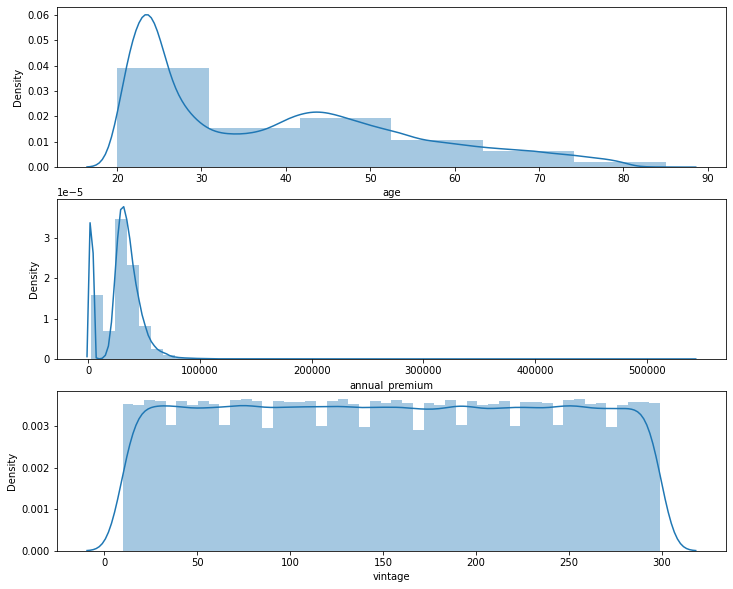

In [12]:
fig, axs = plt.subplots(3, figsize = (12,10))
sns.distplot(num_attributes['age'], ax=axs[0], bins = 6)
sns.distplot(num_attributes['annual_premium'], ax=axs[1])
sns.distplot(num_attributes['vintage'], ax=axs[2]);

> Na primeira avaliação nos dados usando métodos estatisticos, não foi percebido nenhum tipo de anormalidade nos dados. 

#### 1.5.1.2 Numerica Atributes No Odinals

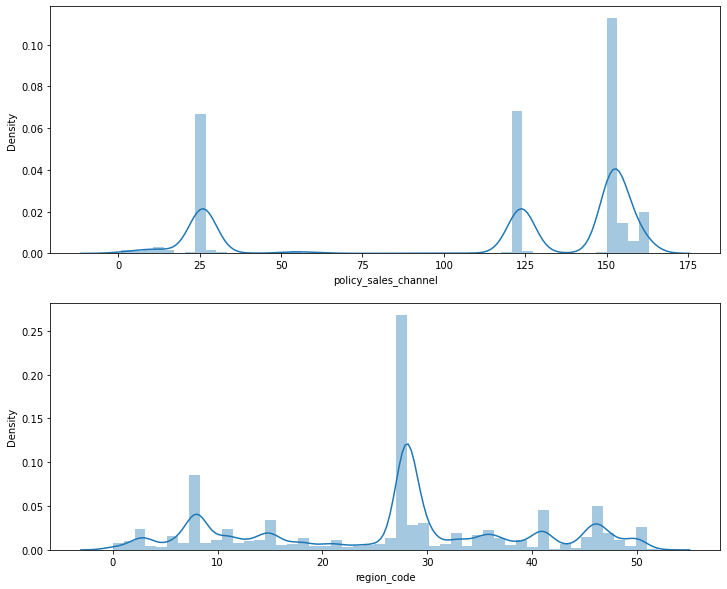

In [13]:
fig, axs = plt.subplots(2, figsize = (12,10))
sns.distplot(num_attributes_no['policy_sales_channel'], ax=axs[0], bins = 50)
sns.distplot(num_attributes_no['region_code'], ax=axs[1]);


In [14]:
print('Quantidade de canais de contato:', len(num_attributes_no['policy_sales_channel'].unique()) )
print('Canal de contato mais usado:', num_attributes_no['policy_sales_channel'].mode() )
print(f'O canal 152, tem frequência de uso de : {(len(df1.policy_sales_channel.loc[df1["policy_sales_channel"] == 152.0])/381109)*100 :.4}% ')

Quantidade de canais de contato: 155
Canal de contato mais usado: 0    152.0
Name: policy_sales_channel, dtype: float64
O canal 152, tem frequência de uso de : 35.37% 


In [15]:
print('Quantidade de region codes:', len(num_attributes_no['region_code'].unique()) )
print('Region code mais usado:', num_attributes_no['region_code'].mode() )

Quantidade de region codes: 53
Region code mais usado: 0    28.0
Name: region_code, dtype: float64


> Na primeira avaliação estatisticao dos dados, separados como dados não ordinais, perecebeu-se que apesar de uma grande variedade de canais de venda, um pequeno número destes concentrão o maior número de uso. 
> Na região code, a uma maior distribuição, porém a uma região com grande concentraçao. 

### 1.5.2 Categorical Atributes

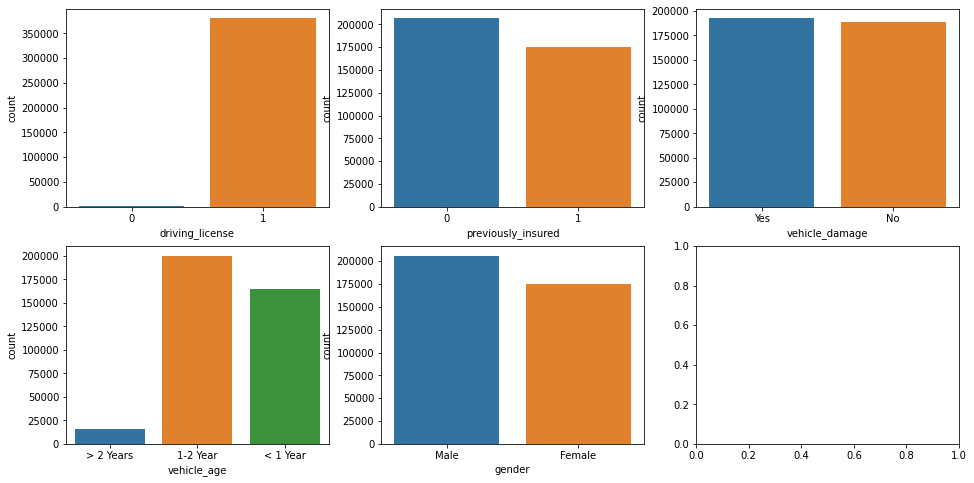

In [16]:
fig, axs = plt.subplots(ncols = 3, nrows = 2,  figsize = (16,8))

sns.countplot(x ='driving_license', data= cat_attributes, ax=axs[0][0]);
sns.countplot(x = 'previously_insured', data=cat_attributes, ax=axs[0][1]);
sns.countplot(x = 'vehicle_damage', data=cat_attributes, ax=axs[0][2]);

sns.countplot(x = 'vehicle_age', data=cat_attributes,ax=axs[1][0]);
sns.countplot(x = 'gender', data=cat_attributes,ax=axs[1][1]);

In [17]:
#% driving_license
possui_cnh = len(cat_attributes.loc[cat_attributes['driving_license'] == 1 ])
sem_cnh = len(cat_attributes.loc[cat_attributes['driving_license'] == 0 ])
print('driving_license:\n')
print(f'Número de clientes com CNH: {possui_cnh} ( {(possui_cnh/(possui_cnh+sem_cnh))*100 :.4}% )')
print(f'Número clientes sem CNH:    {sem_cnh}    ( {(sem_cnh/(possui_cnh+sem_cnh))*100 :.4}% )\n')
print('***********************************************************************************************\n')

#% previously_insured
possui_seg_auto = len(cat_attributes.loc[cat_attributes['previously_insured'] == 1 ])
sem_seg_auto = len(cat_attributes.loc[cat_attributes['previously_insured'] == 0 ])
print('previously_insured:\n')
print(f'Número de clientes com seguro de automóvel: {possui_seg_auto} ( {(possui_seg_auto/(possui_seg_auto+sem_seg_auto))*100 :.4}% )')
print(f'Número clientes sem seguro de automóvel:     {sem_cnh}    ( {(sem_seg_auto/(possui_seg_auto+sem_seg_auto))*100 :.4}% )')
print('***********************************************************************************************\n')

#% vehicle_damage
auto_danificado = len(cat_attributes.loc[cat_attributes['vehicle_damage'] == 'Yes' ])
auto_nao_danificado = len(cat_attributes.loc[cat_attributes['vehicle_damage'] == 'No' ])
print('vehicle_damage :\n')
print(f'Carros que já tiveram danos: {auto_danificado}    ( {(auto_danificado/(auto_danificado+auto_nao_danificado))*100 :.4}% )')
print(f'Carros que não tiveram danos:{auto_nao_danificado}    ( {(auto_nao_danificado/(auto_danificado+auto_nao_danificado))*100 :.4}% )')
print('***********************************************************************************************\n')

#% vehicle_age
maior_2_anos = len(cat_attributes.loc[cat_attributes['vehicle_age'] == '> 2 Years' ])
de_1_a_2_anos = len(cat_attributes.loc[cat_attributes['vehicle_age'] == '1-2 Year' ])
menor_1_ano = len(cat_attributes.loc[cat_attributes['vehicle_age'] == '< 1 Year' ])
print('vehicle_age :\n')
print(f'Carros com mais de 2 anos:  {maior_2_anos}    ( {(maior_2_anos/(maior_2_anos+de_1_a_2_anos+menor_1_ano))*100 :.4}% )')
print(f'Carros entre 1 a 2 anos:    {de_1_a_2_anos}   ( {(de_1_a_2_anos/(de_1_a_2_anos+de_1_a_2_anos+menor_1_ano))*100 :.4}% )')
print(f'Carros com menso que 1 ano: {menor_1_ano}   ( {(menor_1_ano/(de_1_a_2_anos+de_1_a_2_anos+menor_1_ano))*100 :.4}% )')

print('***********************************************************************************************\n')

#% gender
homem = len(cat_attributes.loc[cat_attributes['gender'] == 'Male' ])
mulher = len(cat_attributes.loc[cat_attributes['gender'] == 'Female' ])
print('gender :\n')
print(f'Clientes do sexo masculino:{homem}    ( {(homem/(homem+mulher))*100 :.4}% )')
print(f'Clientes do sexo feminino: {mulher}    ( {(mulher/(homem+mulher))*100 :.4}% )')
print('***********************************************************************************************\n')

driving_license:

Número de clientes com CNH: 380297 ( 99.79% )
Número clientes sem CNH:    812    ( 0.2131% )

***********************************************************************************************

previously_insured:

Número de clientes com seguro de automóvel: 174628 ( 45.82% )
Número clientes sem seguro de automóvel:     812    ( 54.18% )
***********************************************************************************************

vehicle_damage :

Carros que já tiveram danos: 192413    ( 50.49% )
Carros que não tiveram danos:188696    ( 49.51% )
***********************************************************************************************

vehicle_age :

Carros com mais de 2 anos:  16007    ( 4.2% )
Carros entre 1 a 2 anos:    200316   ( 35.43% )
Carros com menso que 1 ano: 164786   ( 29.14% )
***********************************************************************************************

gender :

Clientes do sexo masculino:206089    ( 54.08% )
Clientes do sexo femi

> Na primeira avaliação estatística dos dados categorigos, consegue-se perceber que a variável driving_license possui uma grande dominancia de respostas positivas, chegando próximo da totalidade (99,79%).
Na variável vehicle_age, a uma proporção muito baixa de carros que possuem mais de 2 anos. 

### 1.5.1. Response Variable

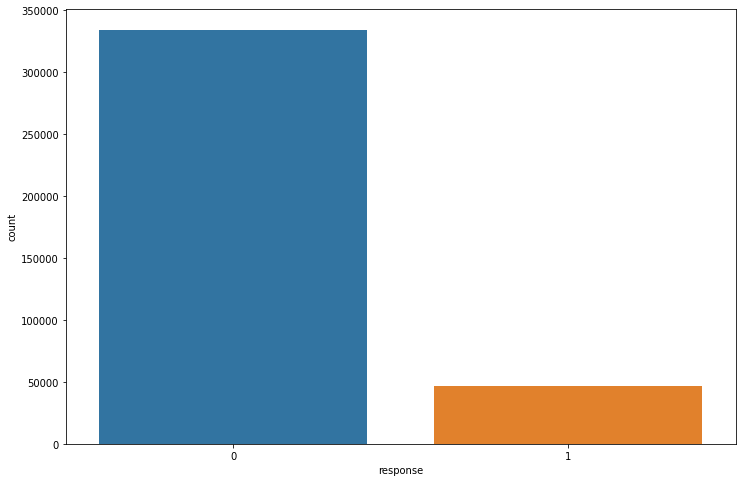

In [18]:
sns.countplot(target_atribute).figure.set_size_inches(12, 8);

In [19]:
sim = len(df1.loc[df1['response'] == 1 ])
nao = len(df1.loc[df1['response'] == 0 ])
print('response :\n')
print(f'Número de clientes que tiveram interesse interesse: {sim}    ( {(sim/(sim+nao))*100 :.4}% )')
print(f'Número de clientes que não tiveram interesse:       {nao}    ( {(nao/(sim+nao))*100 :.4}% )')
print('***********************************************************************************************\n')

response :

Número de clientes que tiveram interesse interesse: 46710    ( 12.26% )
Número de clientes que não tiveram interesse:       334399    ( 87.74% )
***********************************************************************************************



# 2.0. FEATURE ENGINEERING

In [20]:
df2 = df1.copy()

-  2.1. Mapa Mental de Hipoteses
-  2.2. Criação das Hipotéses(Loja, Produto, tempo)
-  2.3. Hipoteses Finais. 
-  2.4. Feature Engineering

## 2.2. Criação das Hipóteses


### 2.2.1 Hipoteses  Cliente

1. Clientes do gênero feminino possuem proporcionalmente, mais interesse pelo seguro.
2. Clientes em faxas etárias de idade maior possuem mais interesse pelo seguro. 

### 2.2.2 Hipoteses  Seguro

1. Clientes que pagaram mais premio para o seguro de saúde possuem mais interesse pelo seguro. 
2. Número de dias que o cliente se associou à empresa através da compra do seguro.
3. Clientes que utilizaram os 5 canais de contato mais usados, possuem mais interesse pelo seguro.

### 2.2.3 Hipoteses Automóvel

1. Clientes com automóveis mais novos tem mais interesse pelo seguro.
2. Clientes com automóveis que já sofreram danos, possuem mais interesse pelo seguro. 
3. Clientes com CNH possuem mais interesse pelo seguro. 
4. Clientes que ainda não possuem seguro de automóvel possuem mais interese pelo seguro. 

### 2.2.4. Hipoteses Região

1. Clientes em regiões de grandes centros urbanos tem mais interesse pelo seguro. 
2. Clientes em regiões com maior indice de assaltos tem mais interesse pelo seguro.

## 2.3 Criação Final de Hipotéses

1. Clientes do gênero feminino possuem proporcionalmente, mais interesse pelo seguro.
2. Clientes em faxas etárias de idade maior possuem mais interesse pelo seguro. 
3. Clientes que pagaram mais premio para o seguro de saúde possuem mais interesse pelo seguro. 
4. Clientes com automóveis mais novos e que não possuem seguro, tem mais interesse pelo seguro.
5. Clientes com automóveis que já sofreram danos, possuem mais interesse pelo seguro. 
6. Clientes com CNH possuem mais interesse pelo seguro. 
7. Clientes que ainda não possuem seguro de automóvel possuem mais interese pelo seguro. 

## 2.4. Features Engineering

In [21]:
#Vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years'
                                               else 'between_1_2_year'  if x == '1-2 Year'
                                               else 'below_1_year')
#Vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' 
                                                    else 0 )

# 3.0. Data Filtering

In [22]:
df3 = df2.copy()

# 4.0. EDA

In [23]:
df4 = df3.copy()

Faze univariada, bivariada, teste de hipoteses... 

## 4.1. Univariate Analysis

Em um projeto de classificação o objetivo é encontrar quais features tem uma separação natural ou mais separadas naturalmente para ajudar o modelo. O modelo sempre quer descobrir um corte no espaço que consegue separe quem tem interesse no produto e quem não tem interesse no produto. 
Quando usamos variáveis unidirecional, queremos plotar uma distribuição e olha esta projeção no eixo x, para dizer se são misturadas ou não. 
Do ponto gráfico podemos analisar diferença de médias, dos quartis, sobreposição entre distribuição. Assim podemos ter uma idéia se a váriavel irá 'bagunçar' ou 'separar' o dataset. Lembrando que o interesse aqui é encontrar as variáveis separadas entre si. 

### - Variable "age"
Possui relevancia para o modelo

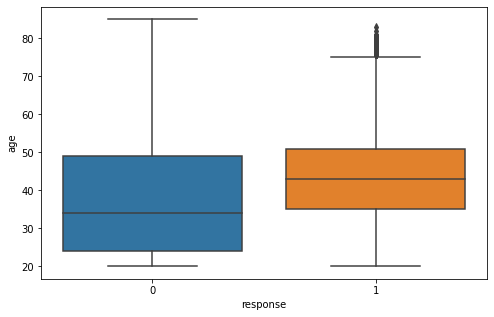

In [24]:
#age
sns.boxplot( x= 'response' , y= 'age', data= df4 ).figure.set_size_inches(8,5);

> Interpretação do boxplot variavel ageXresponse: 
> - No grupo de pessoas que não estão interessados, temos a mediana próximo dos 35 anos, o primeiro ao terceiro >quartis estão dentro do intervalo de 25 a 50 anos.
>- No grupo de pessoas que estão interessados, temos a mediana próxima a 45 anos, e o primeiro quartil esta acima da mediana do primeiro grupo, vemos uma concentração nos primeiro e terceiro quartis na faixa de 35 e 50.
>- Numa primeira analise vemos que a um interesse maior das pessoas mais velhas contra as mais novas, nos indicando que esta variável pode ter importância na classificação. 

Interested People: 46710 
Not Interested People: 334399 


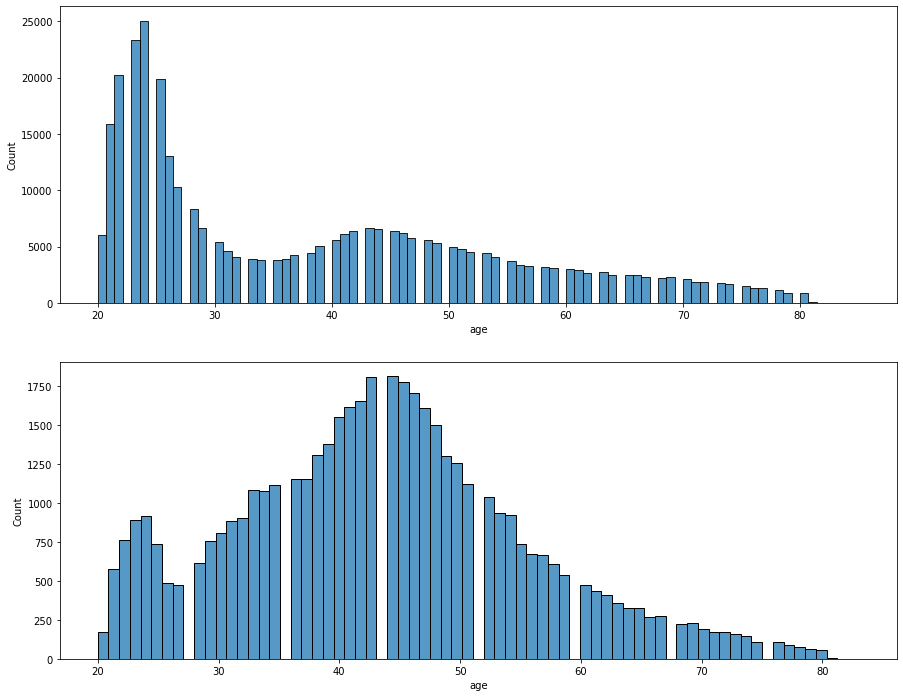

In [25]:
#Histogram not interested 
plt.subplot( 2, 1, 1 ).figure.set_size_inches(15,12);
aux0 = df4.loc[ df4['response'] == 0, 'age' ]
sns.histplot( aux0 );

#Histogram interested 
plt.subplot( 2, 1, 2 );
aux0 = df4.loc[ df4['response'] == 1, 'age' ]
sns.histplot( aux0 );
print( f"Interested People: {len(df4.loc[ df4['response'] == 1, 'age' ])} ")
print( f"Not Interested People: {len(df4.loc[ df4['response'] == 0, 'age' ])} ")

> Ao plotarmos a distribuição: 
> - Pessoas que não possuem interesse: Temos com relação a amplitude, uma concentração de pessoas muito maior por volta dos 25 anos. A distribuição não se comporta como uma normal, se assemelha mais a uma Poison. 
> - Pessoas que possuem interese: A concentração fica em torno de 40 a 50 anos, a distribuição fica masi próxima de uma distribuição normal. Percebemos que o interesse cai bastante após a idade dos 50 anos e poucas pessoas interessadas com idades da parte superior do gráfico. 
> Obs:. Temos um número muito maior de pessoas que não possuem interesse, assim podemos ficar alerta de apesar de a idade ser representativa, temos o problema de diferença de volumes entre as classes.

### - Variable "annual_premium"
Pouca relevância para o modelo

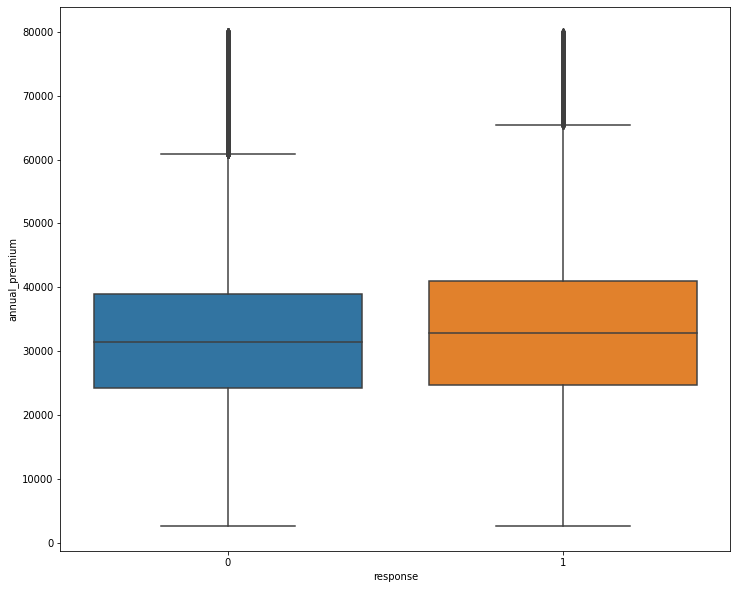

In [26]:
#annual_premium
aux =df4[df4['annual_premium'] < 80000 ]
sns.boxplot( x= 'response' , y= 'annual_premium', data= aux ).figure.set_size_inches(12,10);


> Para analisar o box-plot da 'annual_premium' foi necessário plotar diminuindo os outliers, assim plotamos com filtro de menores de 8000.
> Ao comparamos os box-plot para as duas respostas, vemos que as medianas estão muito próximas assim como a concentração entre os quartis. Assim percebemos que esta variável sozinha não nos ajudara no nosso modelo, talvez combinada com outra variável venha a ter utilidade. 

Interested People: 46710 
Not Interested People: 334399 


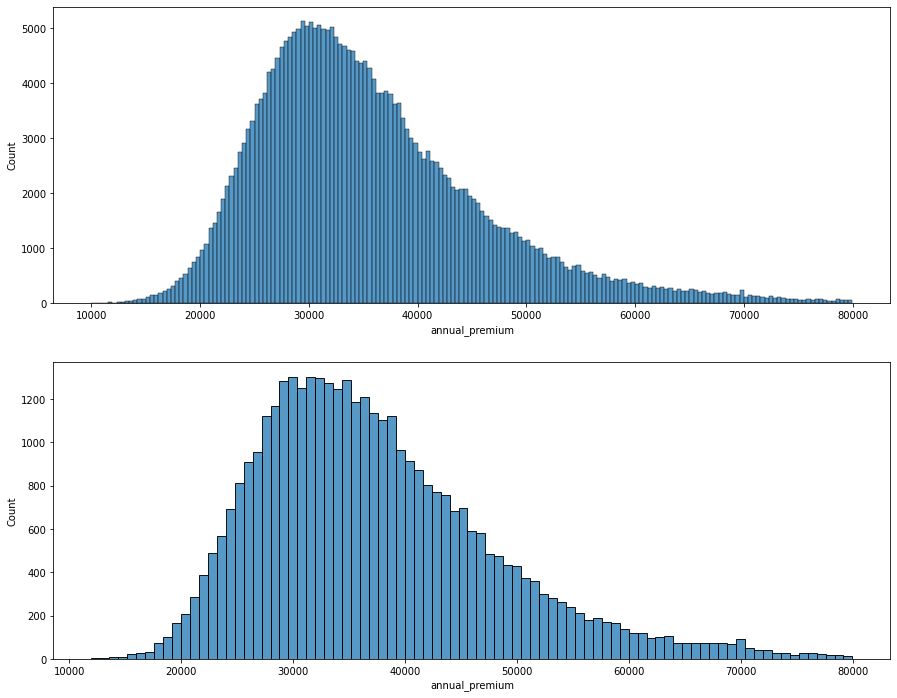

In [27]:
aux =df4[ (df4['annual_premium'] > 10000) & (df4['annual_premium'] <80000) ]

#Histogram not interessed annual_premium
plt.subplot( 2, 1, 1 ).figure.set_size_inches(15,12);
aux0 = aux.loc[ df4['response'] == 0, 'annual_premium' ]
sns.histplot( aux0 );

#Histogram annual_premium
plt.subplot( 2, 1, 2 );
aux0 = aux.loc[ df4['response'] == 1, 'annual_premium' ]
sns.histplot( aux0 );
print( f"Interested People: {len(df4.loc[ df4['response'] == 1, 'age' ])} ")
print( f"Not Interested People: {len(df4.loc[ df4['response'] == 0, 'age' ])} ")

>Ao plotar a distribuição sem os out-liers, podemos ver uma distribuição bem parecida, além de considearar que a diferenã de volume é bem alta. Logo, reafirmamos que esta variável tera pouco relevância de forma idependênte no nossso modelo podendo atrapalhar mais do que ajudar. 

### Variable "driving_license"
Não conclusiva de maneira isolada

> Pouco conclusiva, analisando isoladamente temos que a maioria das pessoas entre as que dirigem(87%) não possuem interesse no seguro. Poŕém analisar esta variável sem levar em consideração outros fatores não esclarece muita coisa. Ou qual a propensão

In [28]:
pd.crosstab( df4['driving_license'], df4['response'] )

response,0,1
driving_license,,
0,771,41
1,333628,46669


In [29]:
print(f'Percentual de pessoas que possuem CNH e tiveram interesse:    {(46669/(333628+46669))*100 :.4} % ')
print(f'Percentual de pessoas que não possuem CNH e tiveram interesse: {(41/(41+771))*100 :.4} % ')

Percentual de pessoas que possuem CNH e tiveram interesse:    12.27 % 
Percentual de pessoas que não possuem CNH e tiveram interesse: 5.049 % 


> Fazendo a tabela cruzada percebemos que o interesse das pessoas que tem licensa é maior, pois temos que entre os que não possuem licensa o interesse cai para 5,3%(41 dos 812) contra 12% dos que tem carteira de motorista. 

### Variable "region_code"
pouca relevância para o modelo

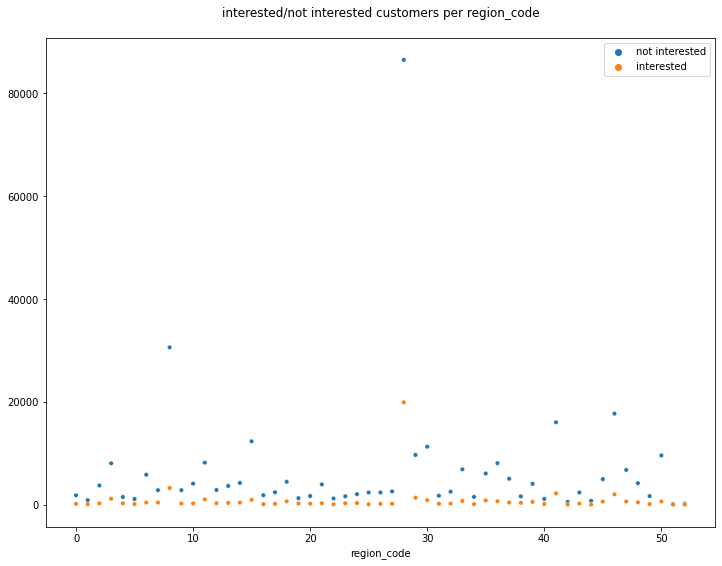

In [30]:
#plot scatterplot region_code
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
aux['response'] = aux['response'].map({0:'not interested', 1:'interested'})
ax = sns.scatterplot( x='region_code', y = 'id', hue = 'response', data = aux, s=20)
ax.set_title('interested/not interested customers per region_code\n')
ax.legend(title='')
ax.set_ylabel('')
ax.figure.set_size_inches(12,9);




> Mesmo que algumas regiões isoladamente tenha uma diferença expressiva de pessoas que tiveram interesse e não tiveram interesse, podemos ver no gráfico que a grande maioria possui um comportamento parecido. Assim, de forma isolada a variável region_code possui pouca significância para o modelo. 

### Variable "previously_insured"
Possui relevância para o modelo

In [31]:
#% tabela interesse X ja tem seguro
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x/x.sum(), axis =1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [32]:
a = (46552*100)/(159929+46552)
b = (158*100)/(174470+158)
print( f' Pocentagem dos que não tem seguro e tem interesse: {a:.4}%')
print( f' Pocentagem dos que tem seguro e não tem interesse: {b:.3}%')

 Pocentagem dos que não tem seguro e tem interesse: 22.55%
 Pocentagem dos que tem seguro e não tem interesse: 0.0905%


>Fazendo a tabela de contigência, onde nos mostra a relação quantas pessoas que já posssuem ou não seguro de automóvel e possuem ou não iteresse no seguro oferecido. 
> Entre as pessoas que não possuem seguro, o interesse foi de 29,11% contra 0.09% das que já possuem. Aqui fica claro que esta variável é importante e relevante, pois claramente os clientes que não possuem seguro tem maior propensão a querer seguro.

### Variable "vehicle_age"
Parte relevânte para o modelo


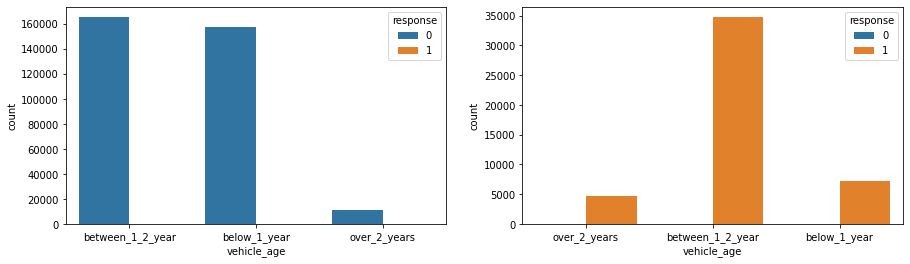

In [33]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4));
sns.countplot(df4[df4['response']==0]['vehicle_age'], hue=df4['response'], ax=axs[0]);
sns.countplot(df4[df4['response']==1]['vehicle_age'], hue=df4['response'], ax=axs[1]);

In [34]:
aux=pd.crosstab(df4['vehicle_age'], df4['response'])
aux['afirmative(%)'] = (aux[1]/(aux[1]+aux[0])*100 )
aux

response,0,1,afirmative(%)
vehicle_age,,,
below_1_year,157584,7202,4.370517
between_1_2_year,165510,34806,17.375547
over_2_years,11305,4702,29.374649


> Notamos que com pessoas que possuem carros com mais de 2 anos, as respostas entre querer ou não seguro ficaram pareceidas 29% contra 12%, estes dados podem atrapalhar o modelo
> Já nos casos de carros com menos de 1 ano e entre 1 e 2 houve maior discrepância nas resposta, oq faz ter uma discriminção razoável para o modelo. 

### Variable "policy_sales_channel"
Não conclusiva

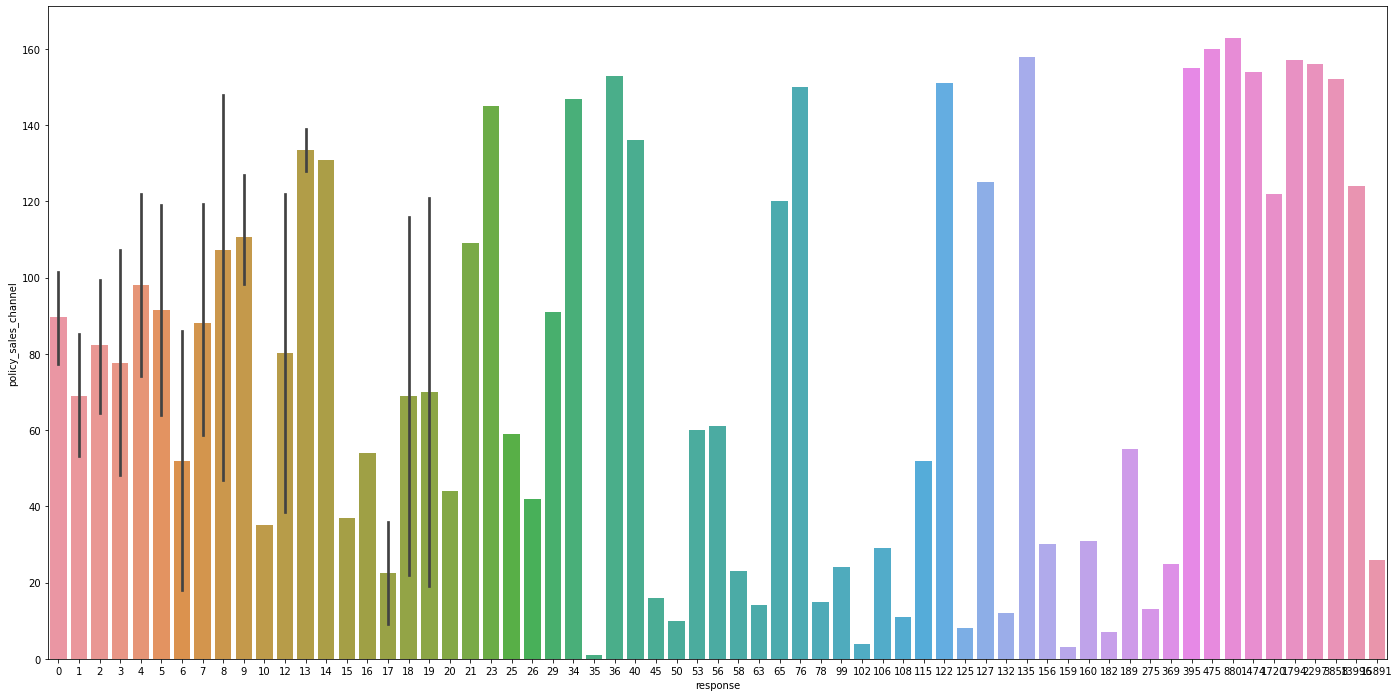

In [35]:
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux ).figure.set_size_inches(24, 12)

### Variable "vintage"
Sem Relevância

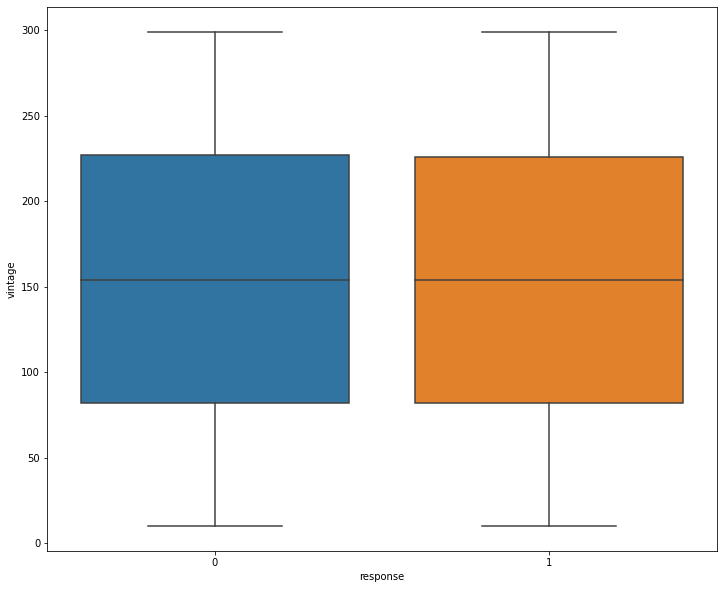

In [36]:
sns.boxplot( x= 'response' , y= 'vintage', data= df4 ).figure.set_size_inches(12,10);

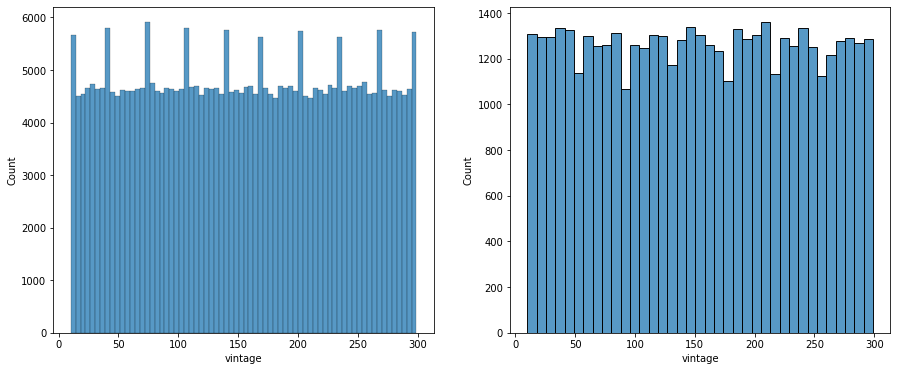

In [37]:

plt.subplot( 1, 2, 1 )
aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux00 ).figure.set_size_inches(12,6);

plt.subplot( 1, 2, 2 ).figure.set_size_inches(15,6)
aux00 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux00 );

> Esta variável não possuí relevância, pois a maneira q foi usada o tempo de  que os clientes possuem, é renovada anualmente, o que faz com que seja praticamente linear, quanto a resposta.

### Variable "vehicle_damage"
Possui Relevância

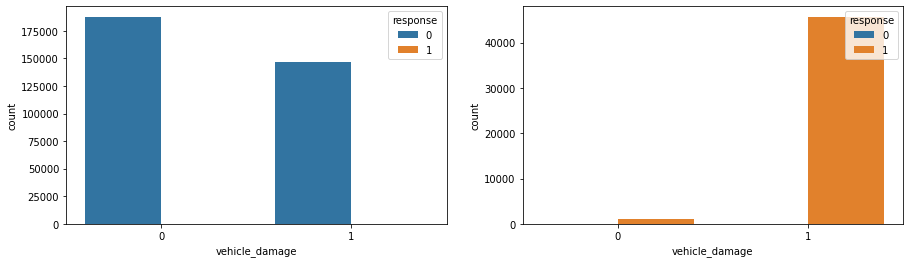

In [38]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4));
sns.countplot(df4[df4['response']==0]['vehicle_damage'], hue=df4['response'], ax=axs[0]);
sns.countplot(df4[df4['response']==1]['vehicle_damage'], hue=df4['response'], ax=axs[1]);

In [39]:
aux = pd.crosstab(df4['vehicle_damage'], df4['response'])
aux['afirmative(%)'] = (aux[1]/(aux[1]+aux[0])*100 )
aux

response,0,1,afirmative(%)
vehicle_damage,,,
0,187714,982,0.520414
1,146685,45728,23.765546


> Conseguimos perceber que as pessoas que ja tiveram algum problema com o carro, possuem mais interesse em adiquirir o seguro. 

### Variable "gender"
Pouco relevante para o modelo

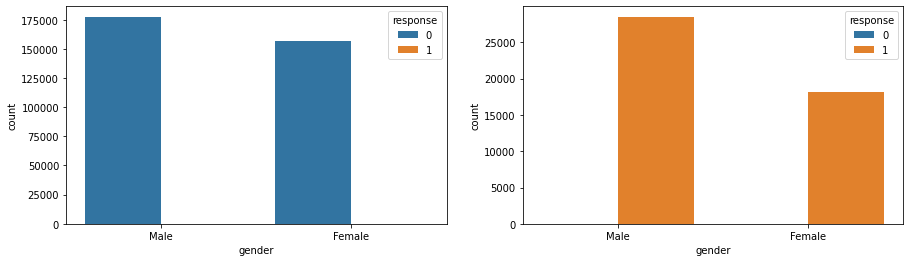

In [40]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4));
sns.countplot(df4[df4['response']==0]['gender'], hue=df4['response'], ax=axs[0]);
sns.countplot(df4[df4['response']==1]['gender'], hue=df4['response'], ax=axs[1]);

In [41]:
aux=pd.crosstab(df4['gender'], df4['response'])
aux['afirmative(%)'] = (aux[1]/(aux[1]+aux[0])*100 )
aux

response,0,1,afirmative(%)
gender,,,
Female,156835,18185,10.390241
Male,177564,28525,13.841107


> A diferença entre mulheres e homem ao demonstrar interesse pelo seguro de carro é muito pequena. 

### Relevant Variables

1. Possui Relevância:
- age
- previously_insured
- vehicle_damage

2. Pouca Relevância:
- annual premium 
- region code
- vehicle_age
- gender

3. Inconclusivas ou Não relevântes:
- driving_license
- policy_sales_channel
- vintage
- gender




## 4.2. Bivariate Analysis

### H1. Clientes do gênero feminino possuem proporcionalmente, mais interesse pelo seguro.
<font color=red>Falso: Possuem menos interesse.

In [42]:
aux=pd.crosstab(df4['gender'], df4['response'])
aux['afirmative(%)'] = (aux[1]/(aux[1]+aux[0])*100 )
aux

response,0,1,afirmative(%)
gender,,,
Female,156835,18185,10.390241
Male,177564,28525,13.841107


### H2. Clientes em faxa etárias de idade maior possuem mais interesse pelo seguro.
<font color=red>Falso: A faxa etária de maior interesse é de 42 a 52 anos. Porém cai a partir desta idade.

In [43]:
# 5 quartiles
df4.age.quantile([i / 5 for i in range(1, 5)])

0.2    24.0
0.4    29.0
0.6    42.0
0.8    53.0
Name: age, dtype: float64

In [44]:
# separar age em 5 partes proporcionais
q1 = len(df4[['age', 'response']].loc[(df4['response'] == 1) & (df4['age'] < 25)])
q2 = len(df4[['age', 'response']].loc[(df4['response'] == 1) & ( df4['age'] > 24) & (df4['age'] < 30) ])
q3 = len (df4[['age', 'response']].loc[(df4['response'] == 1) & ( df4['age'] > 29) & ( df4['age'] < 42) ])
q4 = len(df4[['age', 'response']].loc[(df4['response'] == 1) & ( df4['age'] > 41) & ( df4['age'] < 53) ])
q5 = len(df4[['age', 'response']].loc[(df4['response'] == 1) & ( df4['age'] > 52)])
total1=46710

# definir classes e labels
classes = [ q1, q2, q3, q4, q5 ]
labels = ['20_24', '25_29', '30_41', '42_52', '53_85']
percentual= [((q1/total1)*100), (q2/total1)*100, (q3/total1)*100, (q4/total1)*100, (q5/total1)*100 ]

#frequencia
frequencia = pd.DataFrame({'afirmative': classes, 'afirmative(%)': percentual } , index = labels)

frequencia.sort_values('afirmative', ascending = False )

,afirmative,afirmative(%)
42_52,16569,35.472062
30_41,14021,30.017127
53_85,9746,20.864911
20_24,3313,7.092700
25_29,3061,6.553201


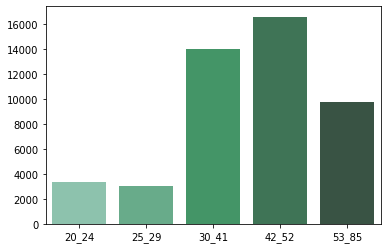

In [45]:
sns.barplot(labels, classes, palette="BuGn_d", data=frequencia);

> Ao dividir em 5 faixa e etárias proporcional a quantidade de pessoas em cada faixa de idade, constata-se que após os 30 anos a um cresimento de interesse com relação a faixa etárias mais novas, porem após a faixa dos 53 este interesse cai, não tendo um crescimento diretamente proporcional a idade no interesse. 

### H3. Clientes que pagaram mais premio para o seguro de saúde possuem mais interesse pelo seguro. 
<font color=red>Falso: Ao separar por faixas proporcionais, conseguimos perceber uma pequena tendência de alta quando se pagou mais premio. Mas não possui uma relação totalmente direcinal. 

In [46]:
# 5 quartiles
df4.annual_premium.quantile([i / 4 for i in range(1, 4)])

0.25    24405.0
0.50    31669.0
0.75    39400.0
Name: annual_premium, dtype: float64

In [47]:
# separar age em 4 partes proporcionais
q1 = len(df4[['annual_premium', 'response']].loc[(df4['response'] == 1) & (df4['annual_premium'] <= 24405.0 )])
q2 = len(df4[['annual_premium', 'response']].loc[(df4['response'] == 1) & ( df4['annual_premium'] >= 24405.0)   & (df4['annual_premium'] < 31669.0)])
q3 = len (df4[['annual_premium', 'response']].loc[(df4['response'] == 1) & ( df4['annual_premium'] >= 31669.0) & ( df4['annual_premium'] < 39400.0)])
q4 = len(df4[['annual_premium', 'response']].loc[(df4['response'] == 1) & ( df4['annual_premium'] >=39400.0)  ])


total=46710

# definir classes e labels
classes = [ q1, q2, q3, q4 ]
labels = ['A', 'B', 'C', 'D']
percentual= [(q1/total)*100, (q2/total)*100, (q3/total)*100, (q4/total)*100 ]

#frequencia
frequencia = pd.DataFrame({'afirmative': classes, 'afirmative(%)': percentual } , index = labels)

frequencia.sort_values('afirmative', ascending = False )

,afirmative,afirmative(%)
D,13880,29.715264
C,11627,24.891886
A,11261,24.108328
B,9942,21.284522


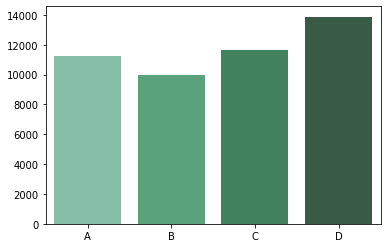

In [48]:
sns.barplot(labels, classes, palette="BuGn_d", data=frequencia);

### H4. Clientes com automóveis mais novos e não possuem seguro de automóvel tem mais interesse pelo seguro.
<font color=red>Falso: Na verdade clientes com automóveis mais velhos e que não possuem seguros tem mais interesse. 

In [49]:
# Total por idade do veiculo que não possui seguro
ns_1ano = len(df4[['vehicle_age']].loc[(df4['previously_insured'] == 0) & (df4['vehicle_age'] == 'below_1_year' )])
ns_1_2anos = len(df4[['vehicle_age']].loc[(df4['previously_insured'] == 0) & (df4['vehicle_age'] == 'between_1_2_year' )])
ns_2anos = len(df4[['vehicle_age']].loc[(df4['previously_insured'] == 0) & (df4['vehicle_age'] == 'over_2_years' )])

# Não possui seguro e reponderam sim
ns_1ano_interece = len(df4[['vehicle_age']].loc[(df4['previously_insured'] == 0) & (df4['vehicle_age'] == 'below_1_year' ) & (df4['response'] == 1)])
ns_1_2anos_interece = len(df4[['vehicle_age']].loc[(df4['previously_insured'] == 0) & (df4['vehicle_age'] == 'between_1_2_year' ) & (df4['response'] == 1)])
ns_2anos_interece = len(df4[['vehicle_age']].loc[(df4['previously_insured'] == 0) & (df4['vehicle_age'] == 'over_2_years' ) & (df4['response'] == 1)])

# tabela
total = [ns_1ano, ns_1_2anos, ns_2anos ]
interece = [ns_1ano_interece, ns_1_2anos_interece, ns_2anos_interece ]
percentual = [(ns_1ano_interece/ns_1ano)*100, (ns_1_2anos_interece/ns_1_2anos)*100, (ns_2anos_interece/ns_2anos)*100 ]
labels = ['below_1_year', 'between_1_2', 'over_2_year']
frequencia = pd.DataFrame({'sem seguro': total, 'afirmative': interece, 'afirmative(%)': percentual }, index = labels )
frequencia

,sem seguro,afirmative,afirmative(%)
below_1_year,55529,7140,12.858146
between_1_2,134991,34711,25.713566
over_2_year,15961,4701,29.453042


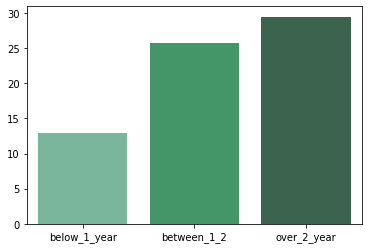

In [50]:
sns.barplot(labels, percentual, palette="BuGn_d", data=frequencia);

### H5. Clientes com automóveis que já sofreram danos, possuem mais interesse pelo seguro.
<font color=red>Verdadeiro: Clientes que já tiveram danos, tem mais interesse pelo seguro. 

In [51]:
aux = pd.crosstab(df4['vehicle_damage'], df4['response'])
aux['afirmative(%)'] = (aux[1]/(aux[1]+aux[0])*100 )
aux

response,0,1,afirmative(%)
vehicle_damage,,,
0,187714,982,0.520414
1,146685,45728,23.765546


### H6. Clientes com CNH possuem mais interesse pelo seguro. 
<font color=red>Verdadeiro: Clientes com CNH, tem mais interesse pelo seguro. 

aux = pd.crosstab(df4['driving_license'], df4['response'])
aux['afirmative(%)'] = (aux[1]/(aux[1]+aux[0])*100 )
aux

### H7. Clientes que ainda não possuem seguro de automóvel possuem mais interese pelo seguro. 
<font color=red>Verdadeiro: Clientes com CNH, tem mais interesse pelo seguro. 

In [52]:
aux = pd.crosstab(df4['previously_insured'], df4['response'])
aux['afirmative(%)'] = (aux[1]/(aux[1]+aux[0])*100 )
aux

response,0,1,afirmative(%)
previously_insured,,,
0,159929,46552,22.545416
1,174470,158,0.090478


### 4.3 Resumo das Hipoteses

In [53]:
 tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Baixa'],
['H4', 'Falsa', 'Media'],
['H5', 'Verdadeira', 'Media'],
['H6', 'Verdadeira', 'Media'],
['H7', 'Verdadeira', 'Alta'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Baixa
H4           Falsa        Media
H5           Verdadeira   Media
H6           Verdadeira   Media
H7           Verdadeira   Alta


## 4.3. Multivariada Analysis

### 4.3.1. Numeric Attributes + Response

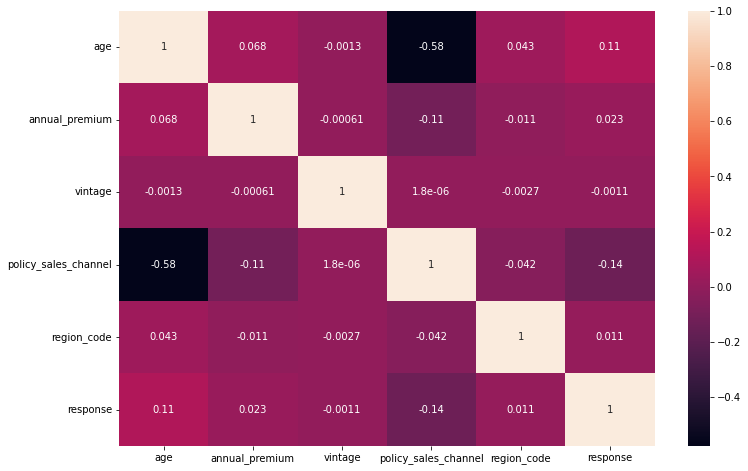

In [54]:
num_attributes    = df1[['age', 'annual_premium', 'vintage', 'policy_sales_channel', 'region_code', 'response' ]]
fig = plt.subplots(figsize = (12,8))
sns.heatmap(num_attributes.corr(), annot = True);

### 4.3.2. Categoric Atributes + response

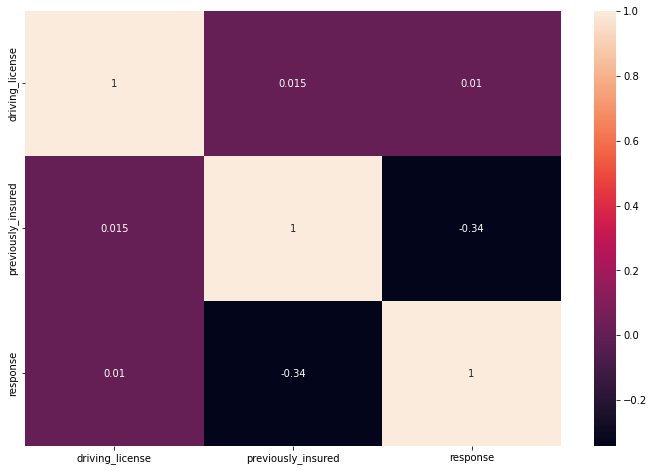

In [55]:
cat_attributes    = df1[['gender', 'driving_license', 'previously_insured', 'vehicle_age', 'vehicle_damage', 'response']]
fig = plt.subplots(figsize = (12,8))
sns.heatmap(cat_attributes.corr(), annot = True);

### 4.3.3. Cross Correlation

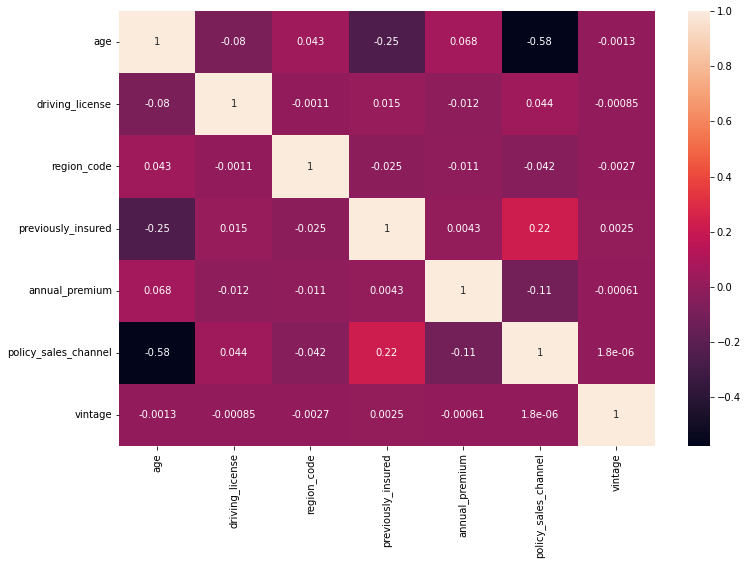

In [56]:
df1aux = df1.drop('response', axis = 1).drop('id', axis = 1)

fig = plt.subplots(figsize = (12,8))
sns.heatmap(df1aux.corr(), annot = True);

# 5.0. Data Preparation

In [57]:
df5 = df4.copy()

In [58]:
X = df4.drop('response', axis = 1 )
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size = 0.20 )

df5 = pd.concat( [x_train, y_train], axis = 1 )

In [59]:
x_valc = x_validation.copy()

## 5.1. Standardization

In [60]:
ss = pp.StandardScaler()

# annual_premium 
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
pickle.dump(ss, open('features/annual_premium_scaler.pkl', 'wb'))


> "annual_premium -  Assume características próximas a normal, porém tem muito outliers
seria necessário fazer um tratamento destes outliers, mas por desconhecimento de detalhes desta variável 
e influência no negócio assumiremos o risco de deixa-la inauterada no primeiro ciclo do Crisp.

>StandardScaler que implementa a TransformerAPI para calcular a média e o desvio padrão em um conjunto de treinamento, de modo a poder reaplicar posteriormente a mesma transformação no conjunto de teste. 

## 5.2. Rescaling

In [61]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

#Age - Não possui distribuição normal, fazer rescaling para normalização.
df5['age'] = mms_age.fit_transform( df5[['age']].values )
pickle.dump(mms_age, open('features/age_scaler.pkl', 'wb'))

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
pickle.dump(mms_vintage, open('features/vintage_scaler.pkl', 'wb'))

> MinMaxScaler do Sklearn é uma técnica de pré-processamento que coloca os dados na mesma escala. A intenção aqui é colocar os dados na mesma escala para melhorar a efinciência do nosso modelo. 

## 5.3. Encoder

In [62]:
#gender - One Hot Encoding / Target Encoding
target_ecode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender' ] = df5['gender'].map( target_ecode_gender )
pickle.dump(target_ecode_gender, open('features/target_ecode_gender_scaler.pkl', 'wb' ))

#region_code - Frequency Encoding / Target Encoding / Weighted Target Encoding
target_encode_region_code = df5.groupby( 'region_code' )[ 'response' ].mean( )
df5.loc[:, 'region_code' ] = df5['region_code' ].map( target_encode_region_code )
pickle.dump(target_encode_region_code, open('features/target_encode_region_code_scaler.pkl', 'wb' ))

#vehicle_age - one Hot Encoding / Label Encoding
df5 = pd.get_dummies( df5, prefix = 'vehicle_age', columns = ['vehicle_age'] )


#policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 )
df5.loc[:, 'policy_sales_channel' ] = df5['policy_sales_channel' ].map( fe_policy_sales_channel )
pickle.dump(fe_policy_sales_channel, open('features/fe_policy_sales_channel_scaler.pkl', 'wb' ))





> Acima de 7 níveis na variável categórica, o uso do One Hot Encoding tornasse inviável, pois cria muitas dimensões, o Target Encoding é mais aconselhado para um primeiro ciclo nestes casos. 

> "region_code" -> Taget Econding - Dada uma variável categórica codificamos cada categoria possível com a média do alvo Y das instâncias com essa categoria. Agrupa-se as instâncias pela sua categoria/realização da variável categórica e tira-se a média de todos os targets Y dessas instâncias. Substitui-se cada categoria da variável pela média calculada para essa categoria.

> "vehicle_age" -> one Hot Encoding - partir de uma variável categórica cria-se um vetor de features binárias onde cada feature representa o pertencimento ou não da instância à uma categoria. 

> "policy_sales_channel" -> Frequency Encoding - Conta a frequencia do que cada valor represente em relação ao total, dando peso maiores para valores que aparecem mais. 

## 5.4 Validation Preparation

In [63]:
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map( target_ecode_gender )

#age 
x_validation.loc[:, 'age']  = mms_age.transform( x_validation[['age']].values )

#region_code 
x_validation.loc[:, 'region_code' ] = x_validation.loc[:, 'region_code' ].map( target_encode_region_code )

#vehicle_age 
x_validation = pd.get_dummies( x_validation, prefix = 'vehicle_age', columns = ['vehicle_age'] )

# annual_premium 
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

#policy_sales_channel 
x_validation.loc[:, 'policy_sales_channel' ] = x_validation['policy_sales_channel' ].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.fit_transform( x_validation[['vintage']].values )

#fillna
x_validation = x_validation.fillna( 0 )


# 6.0. Feature Selection

In [64]:
df6 = df5.copy()

## 6.1 Boruta

In [65]:
#df para treino e teste Boruta
#x_train_b = df6.drop( ['id', 'response'], axis = 1).values
#y_train_b = y_train.values.ravel()

# Define model
#et = en.ExtraTreesClassifier( n_jobs=-1 )

# Define Boruta
#boruta = BorutaPy(et, n_estimators='auto', verbose=2, random_state= 42).fit(x_train_b,y_train_b)



Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
I

In [66]:
#cols_selected = boruta.support_.tolist()

# best features
#x_train_fs = df6.drop( ['id', 'response'], axis=1 )
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()
print('Columns Selected by Boruta: ', cols_selected_boruta)
# not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )
#print('Columns do not Selected by Boruta: ', cols_not_selected_boruta)

Columns Selected by Boruta:  ['age']
Columns do not Selected by Boruta:  ['annual_premium', 'driving_license', 'gender', 'policy_sales_channel', 'previously_insured', 'region_code', 'vehicle_age_below_1_year', 'vehicle_age_between_1_2_year', 'vehicle_age_over_2_years', 'vehicle_damage', 'vintage']


## 6.2 Features Importance

In [65]:
#model definition
forest = en.ExtraTreesClassifier( n_estimators = 250, random_state = 0, n_jobs = -1 )

#data preparation
x_train_n = df6.drop( ['id', 'response'], axis = 1)
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

> Usamos o ExtratreesClassifier, para rodar um modelo com todos nossas features, separadas em treino e após usaremos o metodo "feature_importances_" para termos a classificação das features em termos de importância para nosso modelo

Feature ranking:
                        feature  importance
0                       vintage    0.274100
0                annual_premium    0.245015
0                           age    0.164882
0                   region_code    0.104671
0                vehicle_damage    0.069214
0          policy_sales_channel    0.060269
0            previously_insured    0.054861
0      vehicle_age_below_1_year    0.013575
0  vehicle_age_between_1_2_year    0.006035
0                        gender    0.004676
0      vehicle_age_over_2_years    0.002236
0               driving_license    0.000466


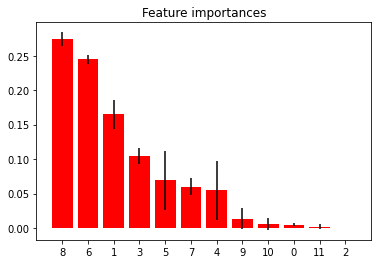

In [66]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]#importanica das arvores ordenada pelo maior valor.

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

> Vamos usar as 7 primeiras features do ranking, pois a partir da setima, a importancia ja cai para menos de 2%. Para um primeiro ciclo de crsping

In [65]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_train = df5[ cols_selected ]
x_val = x_validation[ cols_selected ]
y_val = y_validation.copy()

In [66]:
x_val.shape

(76222, 7)

# 7.0. Machine Learning

> Para medir a performance, usaremos a metrica Precision top k e Recall top . 
> - Precision top k: Conta quantas predições foram corretas até k e dividi por todas as predições realizada pelo modelo até k. 
> - Recall Top K: Conta quantas predições foram corretas até k e dividi por todos os exemplos verdadeiros. 

In [67]:
#copy data
df7 = x_validation.copy()
df7['response'] = y_validation.copy()

## 7.1. KNN(K-Nearest Neighbors)

> KNN: Algoritmo de aprendizadgem supervisionada, classificador onde o aprendizado é baseado “no quão similar” é um dado (um vetor) do outro. O treinamento é formado por vetores de n dimensões.

### 7.1.1. Gain Curve 

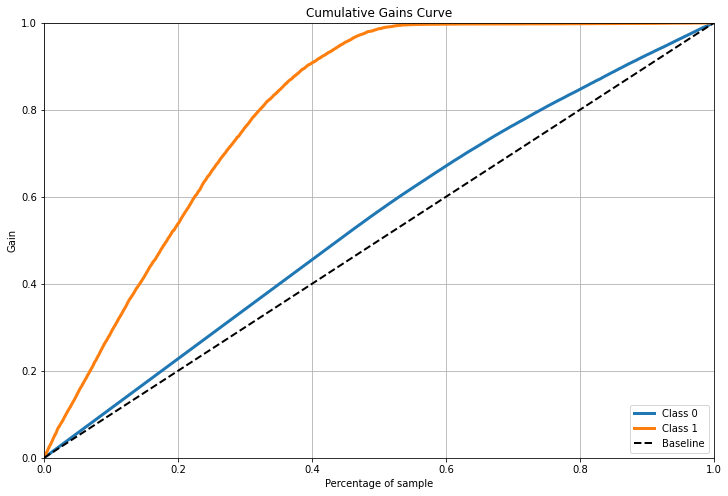

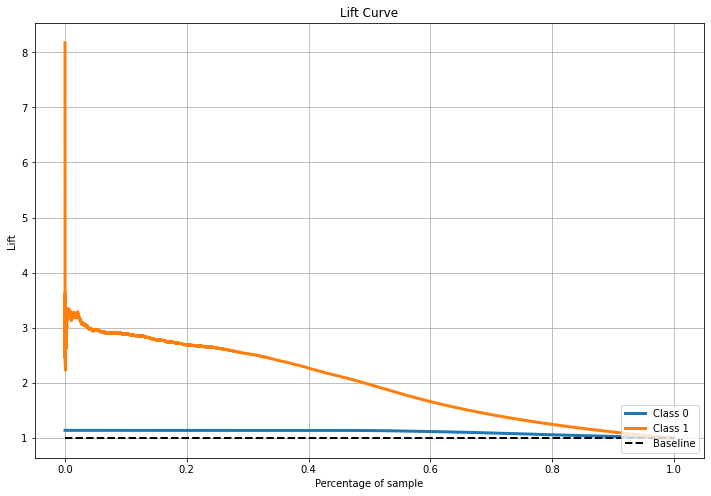

In [169]:
# model definition
knn_model = ng.KNeighborsClassifier( n_neighbors =100 )

# model training
knn_model.fit( x_train, y_train )

# model prediction - Poder de generalização do modelo. 
yhat_knn = knn_model.predict_proba( x_val )

# Accumulative Gain - metrica de ordenação de lista, plot
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn).figure.set_size_inches(12, 8);

#Scikitplot library is therre to help 
skplt.metrics.plot_lift_curve( y_val, yhat_knn ).figure.set_size_inches(12, 8);

> Significado deste plot, (Linha laranja) é a % de pessoas contactadas da lista 'percentage of sample' são necessárias para obter a % de pessoas interessadas 'gain.  Exemplificando, se contatarmos 20% de nossa amostra, alcancaremos pouco mais de 40% das pessoas interessadas. Linha azul é base desordenada e laranja base ordenada.

### 7.1.2. Ranking Top k Performance

In [181]:
 # copy dataframe
dfknn = x_validation.copy()
dfknn['response'] = y_validation.copy()

# propensity score
dfknn['score'] = yhat_knn[:, 1].tolist()

# sort clients by propensity score
dfknn = dfknn.sort_values( 'score', ascending=False )

# table performance top k
df_performancek_knn = top_k_performance( dfknn, df7 )
precision_at_knn = df_performancek_knn['Precision k'].tolist()
df_performancek_knn

,Precision k,Recall K
5%,0.361752,0.147882
15%,0.340651,0.417694
25%,0.322244,0.658552
40%,0.277665,0.907882
60%,0.203306,0.997105
80%,0.152692,0.998499


### 7.1.3 Cross Validation

In [203]:
knn_result_cv = cross_validation(x_train, y_train, 10, 'KNN', knn_model, verbose = True)
knn_result_cv

Fold Number 1/10
Fold Number 2/10
Fold Number 3/10
Fold Number 4/10
Fold Number 5/10
Fold Number 6/10
Fold Number 7/10
Fold Number 8/10
Fold Number 9/10
Fold Number 10/10


,Model Name,Precision top K,Recall K
5%,KNN,0.37+/-0.0123,0.15+/-0.005


## 7.2 Logistic Regression

### 7.2.1. Gain Curve 

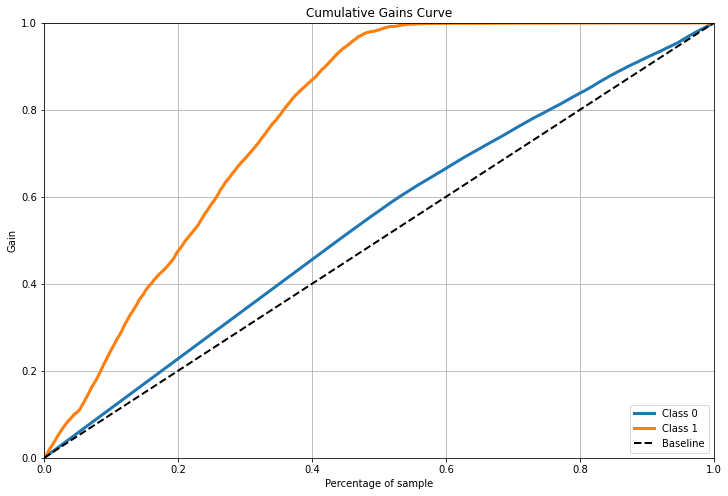

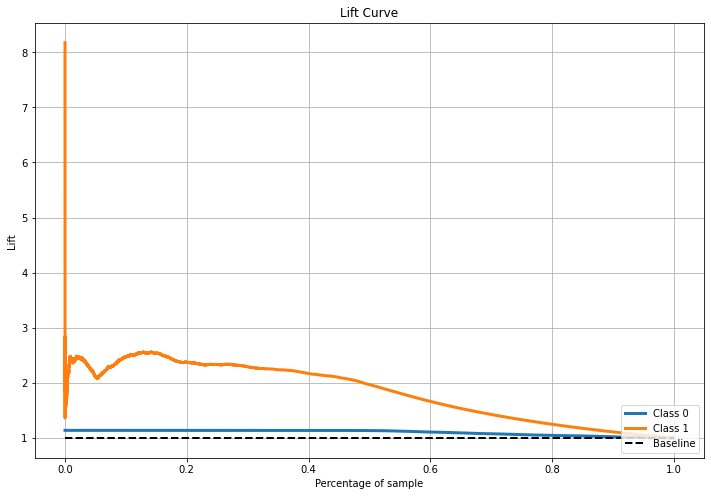

In [188]:
# model definition
lr_model = lm.LogisticRegression( random_state = 42 )

# model training
lr_model.fit( x_train, y_train )

# model prediction - Poder de generalização do modelo. 
yhat_lr = lr_model.predict_proba( x_val )

# Accumulative Gain - metrica de ordenação de lista, plot
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr).figure.set_size_inches(12, 8);

#Scikitplot library is therre to help 
skplt.metrics.plot_lift_curve( y_val, yhat_lr ).figure.set_size_inches(12, 8);

> Os resultados é parecido, porém consegue alcançar 100% da lista com menos pessoas. 

### 7.2.2. Ranking Top k Performance

In [189]:
 # copy dataframe
dflr = x_validation.copy()
dflr['response'] = y_validation.copy()

# propensity score
dflr['score'] = yhat_lr[:, 1].tolist()

# sort clients by propensity score
dflr = dflr.sort_values( 'score', ascending=False )

df_performancek_lr = top_k_performance( dflr, df7 )
precision_at_lr = df_performancek_lr['Precision k'].tolist()
df_performancek_lr

,Precision k,Recall K
5%,0.258657,0.147882
15%,0.310215,0.417694
25%,0.285669,0.658552
40%,0.265694,0.907882
60%,0.203656,0.997105
80%,0.152856,0.998499


### 7.2.3 Cross Validation

In [202]:
lr_result_cv = cross_validation(x_train, y_train, 10, 'Logistic Regression', lr_model, verbose = True)
lr_result_cv

Fold Number 1/10
Fold Number 2/10
Fold Number 3/10
Fold Number 4/10
Fold Number 5/10
Fold Number 6/10
Fold Number 7/10
Fold Number 8/10
Fold Number 9/10
Fold Number 10/10


,Model Name,Precision top K,Recall K
5%,Logistic Regression,0.26+/-0.014,0.11+/-0.0057


## 7.3 Extra Trees

### 7.3.1. Gain Curve 

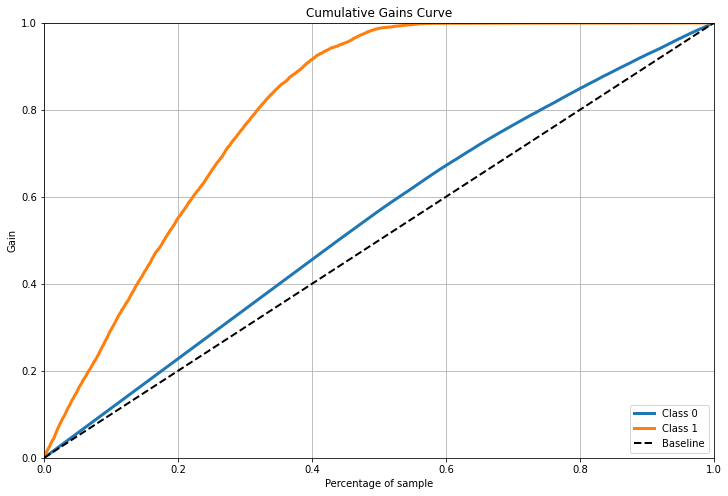

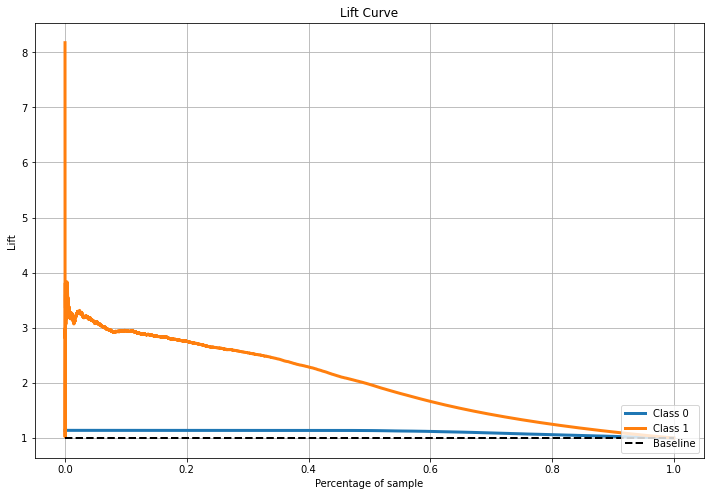

In [191]:
#model definition
et = en.ExtraTreesClassifier( n_estimators = 1000, n_jobs = -1, random_state = 42, max_depth =6 )

#model fit
et.fit( x_train, y_train )

#model predict
yhat_et = et.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et ).figure.set_size_inches(12, 8);

#Scikitplot library is therre to help 
skplt.metrics.plot_lift_curve( y_val, yhat_et ).figure.set_size_inches(12, 8);

# Save trained model
pickle.dump( et, open( 'models/et_model.pkl', 'wb' ) )

### 7.3.2. Ranking Top k Performance

In [192]:
 # copy dataframe
dfet = x_validation.copy()
dfet['response'] = y_validation.copy()

# propensity score
dfet['score'] = yhat_et[:, 1].tolist()

# sort clients by propensity score
dfet = dfet.sort_values( 'score', ascending=False )

df_performancek_et = top_k_performance( dfet, df7 )
precision_at_et = df_performancek_et['Precision k'].tolist()
df_performancek_et

,Precision k,Recall K
5%,0.378279,0.147882
15%,0.348872,0.417694
25%,0.322926,0.658552
40%,0.280157,0.907882
60%,0.203722,0.997105
80%,0.152856,0.998499


### 7.3.3. Cross Validation

In [204]:
et_result_cv = cross_validation(x_train, y_train, 10, 'Extra Trees', et, verbose = True)
et_result_cv

Fold Number 1/10
Fold Number 2/10
Fold Number 3/10
Fold Number 4/10
Fold Number 5/10
Fold Number 6/10
Fold Number 7/10
Fold Number 8/10
Fold Number 9/10
Fold Number 10/10


,Model Name,Precision top K,Recall K
5%,Extra Trees,0.37+/-0.0134,0.15+/-0.0055


## 7.4 Random Forest

### 7.4.1. Gain Curve 

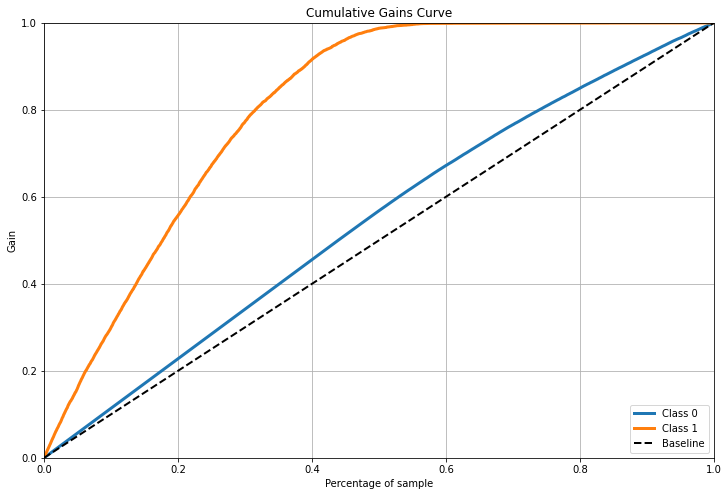

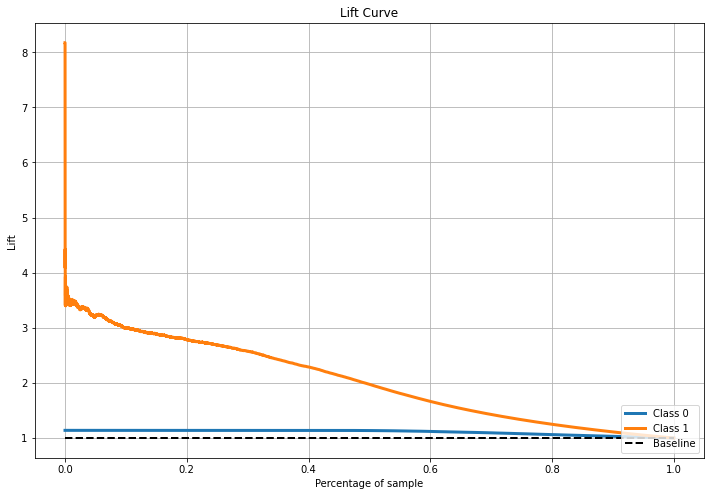

In [194]:
#model definition
rf = en.RandomForestClassifier( n_estimators = 1000, n_jobs=-1, random_state = 42, max_depth = 6 )

# model training
rf.fit( x_train, y_train )

#model prediction
yhat_rf = rf.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf ).figure.set_size_inches(12, 8);

#Scikitplot library is therre to help 
skplt.metrics.plot_lift_curve( y_val, yhat_rf ).figure.set_size_inches(12, 8);

### 7.4.2. Ranking Top k Performance

In [195]:
 # copy dataframe
dfrf = x_validation.copy()
dfrf['response'] = y_validation.copy()

# propensity score
dfrf['score'] = yhat_rf[:, 1].tolist()

# sort clients by propensity score
dfrf = dfrf.sort_values( 'score', ascending=False )

df_performancek_rf = top_k_performance( dfrf, df7 )
precision_at_rf = df_performancek_rf['Precision k'].tolist()
df_performancek_rf

,Precision k,Recall K
5%,0.392707,0.147882
15%,0.352982,0.417694
25%,0.329223,0.658552
40%,0.280092,0.907882
60%,0.203700,0.997105
80%,0.152856,0.998499


### 7.4.3. Cross Validation

In [206]:
rf_result_cv = cross_validation(x_train, y_train, 10, 'Random Forest', rf, verbose = True)
rf_result_cv

Fold Number 1/10
Fold Number 2/10
Fold Number 3/10
Fold Number 4/10
Fold Number 5/10
Fold Number 6/10
Fold Number 7/10
Fold Number 8/10
Fold Number 9/10
Fold Number 10/10


,Model Name,Precision top K,Recall K
5%,Random Forest,0.39+/-0.0157,0.16+/-0.0064


## 7.5. Xgboost Classifier

### 7.5.1. Gain Curve 

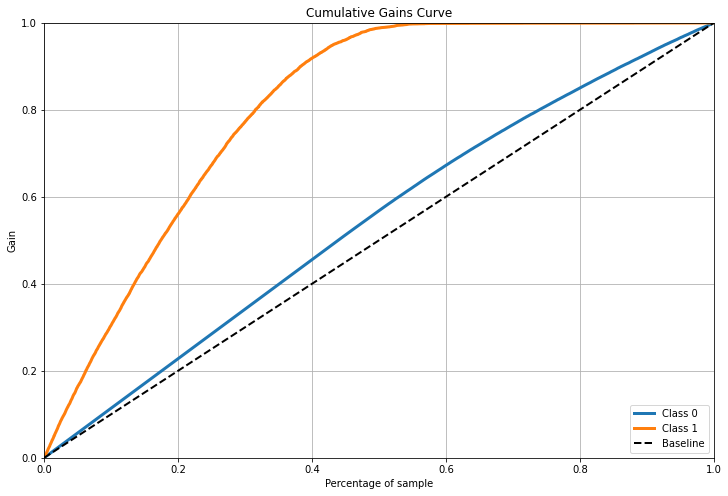

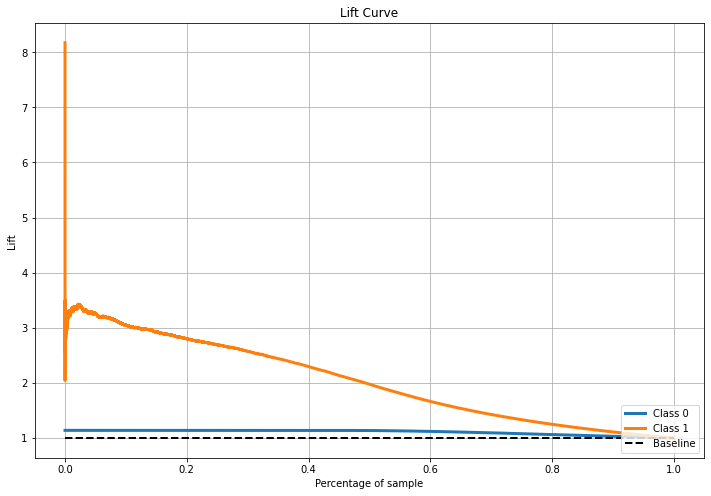

In [197]:
#model definition
xgb = XGBClassifier(n_estimators = 200,
                              max_depth = 6,
                              scale_pos_weight = 1,
                              n_jobs = -1,
                              disable_default_eval_metric = 1
                              
                   )
                   

# model training
xgb.fit( x_train, y_train )

#model prediction
yhat_xgb = xgb.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb).figure.set_size_inches(12, 8);

#Scikitplot library is therre to help 
skplt.metrics.plot_lift_curve( y_val, yhat_xgb ).figure.set_size_inches(12, 8);

### 7.5.2. Ranking Top k Performance

In [198]:
 # copy dataframe
dfxb = x_validation.copy()
dfxb['response'] = y_validation.copy()

# propensity score
dfxb['score'] = yhat_xgb[:, 1].tolist()

# sort clients by propensity score
dfxb = dfxb.sort_values( 'score', ascending=False )

precision_at_xgb = top_k_performance( dfxb, df7 )

precision_at_xgb



df_performancek_xgb = top_k_performance( dfxb, df7 )
precision_at_xgb = df_performancek_xgb['Precision k'].tolist()
df_performancek_xgb

,Precision k,Recall K
5%,0.398741,0.147882
15%,0.357443,0.417694
25%,0.329223,0.658552
40%,0.281010,0.907882
60%,0.203656,0.997105
80%,0.152840,0.998499


### 7.5.3. Cross Validation

In [207]:
xgb_result_cv = cross_validation(x_train, y_train, 10, 'Xgboost Classifier', xgb, verbose = True)
xgb_result_cv 

Fold Number 1/10
Fold Number 2/10
Fold Number 3/10
Fold Number 4/10
Fold Number 5/10
Fold Number 6/10
Fold Number 7/10
Fold Number 8/10
Fold Number 9/10
Fold Number 10/10


,Model Name,Precision top K,Recall K
5%,Xgboost Classifier,0.4+/-0.0068,0.16+/-0.0028


## 7.6. Comparation Models

### 7.6.1. Performance Models Gain Curv

### 7.6.2. Performance Models Precision K

In [140]:
#names columns
name_models ={0: 'KNN', 1: 'Logistic Regression', 2: 'Extra Trees', 3: 'Random Forest', 4: 'Xgboost Classifier'}

#result precisions k models
models_precision_k = [precision_at_knn, precision_at_lr,  precision_at_et, precision_at_rf, precision_at_xgb ]

#dataframe precisions k models comparation
df_comparation_precision_k = pd.DataFrame(models_precision_k ).T.rename(index=percent_k, columns = name_models)
df_comparation_precision_k

,KNN,Logistic Regression,Extra Trees,Random Forest,Xgboost Classifier
5%,0.374869,0.260231,0.363326,0.371721,0.399265
15%,0.344324,0.306892,0.345898,0.350708,0.361291
25%,0.323346,0.283728,0.324868,0.330010,0.332319
40%,0.279272,0.268022,0.281109,0.280879,0.283404
60%,0.204203,0.204443,0.204531,0.204531,0.204421
80%,0.153348,0.153479,0.153479,0.153479,0.153495


> Analisando a tabela com a precision K dos modelos, conseguimos perceber que os modelos KNN e Logistic Regression, tiveram um desempenho um puco a baixo dos outros modelos. Já a Extra Trees, Random Forest e Xgbosst, tiveram um desemepenho semelhante acima de 25%. A Xgboost conseguiu desempenho superior desde os primeiros dados organizados, nas faixas inferiores a 25%

### 7.6.3. Performance Models Recall K

In [420]:
#result precisions k models
models_recall_k = [recall_knn, recall_lr,  recall_et, recall_rf, recall_xgb ]

#dataframe precisions k models comparation
df_comparation_recall_k = pd.DataFrame(models_recall_k ).T.rename(index=percent_k, columns = name_models)
df_comparation_recall_k

,KNN,Logistic Regression,Extra Trees,Random Forest,Xgboost Classifier
5%,0.143996,0.104470,0.142919,0.147550,0.151104
15%,0.399354,0.355412,0.403123,0.410662,0.409693
25%,0.625633,0.547442,0.629079,0.640603,0.646204
40%,0.885083,0.822833,0.887991,0.891007,0.896177
60%,0.997307,0.997307,0.997846,0.998061,0.997954
80%,0.998923,0.999354,0.999677,0.999677,0.998708


> Analisando a tabela de Recall k, novamente o desempenho de KNN e da Logistic Regression. Os outros 3 modelos novamente apresentaram desempenho semelhante no recall, com o Xgboost conseguindo um desempenho levemente melhor. 



### 7.6.4. Performance Models Recall K

In [208]:
modelling_result_cv = pd.concat( [ knn_result_cv, lr_result_cv, et_result_cv, rf_result_cv, xgb_result_cv  ] )
modelling_result_cv

,Model Name,Precision top K,Recall K
5%,KNN,0.37+/-0.0123,0.15+/-0.005
5%,Logistic Regression,0.26+/-0.014,0.11+/-0.0057
5%,Extra Trees,0.37+/-0.0134,0.15+/-0.0055
5%,Random Forest,0.39+/-0.0157,0.16+/-0.0064
5%,Xgboost Classifier,0.4+/-0.0068,0.16+/-0.0028


# 8.0. HYPERPARAMETER FINE TUNING

> Após analizar as performances iniciais dos modelos seguindo as métricas de Precision K e Recall K, o Xgboost Classifier, obteve um melhor resultado, levando ainda em consideração que é um algoritmo não tão pessado como a Random Forest e com uma boa quantidade de parametros para serem melhorados, neste primeiro teste de Crisp, resolvei seguir com este algoritmo. 

>Boost Parameters:

    - eta [default=0.3], diminui o peso em cada etapa, tornando o peso mais robusto.
    - max_depth [default=6], profundidade máxima da arvore, usado para controlar o ajuste excessivo, pois uma profundidade maior permitirá que o modelo aprenda relações muito específicas para uma amostra específica.
    - subsample [default=1],  fração de observações a serem amostras aleatórias para cada árvore.Valores mais baixos tornam o algoritmo mais conservador e evitam overfitting, mas valores muito pequenos podem levar a underfitting.
    - colsample_bytree [default=1], fração de colunas a serem amostras aleatórias para cada árvore.
    - min_child_weight [default=1], Define a soma mínima dos pesos de todas as observações necessárias em um filho. Usado para controlar o ajuste excessivo. Valores mais altos impedem que um modelo aprenda relações que podem ser altamente específicas para a amostra específica selecionada para uma árvore


## 8.1. Random Search - Hyperparameters XGBClassifier

- Para este primeiro ciclo de crisp iremos usar o Random Search, por ser rápido e fácil implementação. 

In [421]:
param = {'n_estimators'    : [ 1000, 1500, 1700, 3000, 3500],
        'eta'              : [0.01, 0.05, 0.1],
        'max_depth'        : [3, 5, 9],
        'subsample'        : [0.5, 0.7, 1],
        'colsample_bytree' : [0.5, 0.7, 1],
        'min_child_weight' : [1, 3, 8, 15]
        }

MAX_EVAL = 20



In [422]:
#final_result = pd.DataFrame()
#for i in range( MAX_EVAL ):
#    #choose values for parameters randomly
#    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
#    print( hp )
#    
#    #model 
#    xgb = XGBClassifier(n_estimators           = hp['n_estimators'],
#                              eta              = hp['eta'],
#                              max_depth        = hp['max_depth'],
#                              subsample        = hp['subsample'],
#                              colsample_bytree = hp['colsample_bytree'],
#                              min_child_weight = hp['min_child_weight'],
#                              n_jobs = -1,
#                              disable_default_eval_metric = 1
#                              
#                   )
#    
#    # model training
#    xgb.fit( x_train, y_train )
#
#    #model prediction
#    yhat_xgb = xgb.predict_proba( x_val )
#       
#    
#    
#     # copy dataframe
#    dfk = x_validation.copy()
#    dfk['response'] = y_validation.copy()
#
#    # propensity score
#    dfk['score'] = yhat_xgb[:, 1].tolist()
#    
#    # sort clients by propensity score
#    dfk = dfk.sort_values( 'score', ascending=False )                              
                          
    #performance
#    print('Precision K: ')
    #Compute precision at k 
#    precision_5percent, data =  precision_at_k( dfk, k=round(len(df7) * 0.05) )
#    print('5%:', precision_5percent)
#    precision_15percent, data = precision_at_k( dfk, k=round(len(df7) * 0.15) )
#    print('15%:', precision_15percent)
#    precision_25percent, data = precision_at_k( dfk, k=round(len(df7) * 0.25) )
#    print('25%:', precision_25percent)
#    precision_40percent, data = precision_at_k( dfk, k=round(len(df7) * 0.40) )
#    print('40%:', precision_40percent)
    
#    print('Recall K: ')   
#    recall_5percent,  data = recall_at_k( dfk, k=round(len(df7) * 0.05) )
#    print('5%:', recall_5percent)
#    recall_15percent, data = recall_at_k( dfk, k=round(len(df7) * 0.15) )
#    print('10%', recall_15percent)
#    recall_25percent, data = recall_at_k( dfk, k=round(len(df7) * 0.25) )
#    print('25%:', recall_25percent)
#    recall_40percent, data = recall_at_k( dfk, k=round(len(df7) * 0.40) )
#    print('40%', recall_40percent)

    #Compute recall at k 
   

 #    recall_k, data = recall_at_k( dfk, k=round(len(df7) * 0.2) )
#    print('recall k:', recall_k)
                            
                   

## 8.2. Performance Final Models Gain Curv (data train)

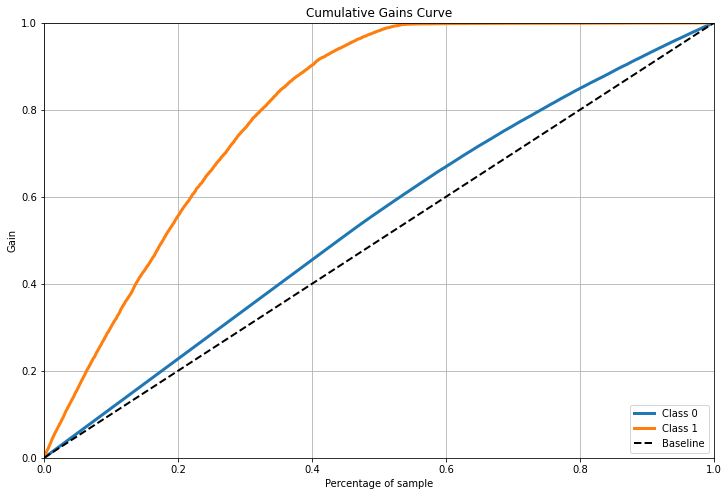

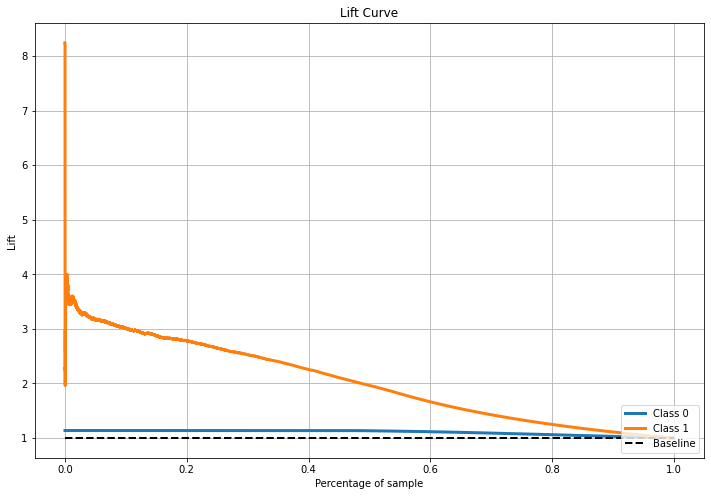

In [130]:
#final parameters model
param_tuning = {'n_estimators': 1700, 
                'eta': 0.05, 
                'max_depth': 3, 
                'subsample': 1, 
                'colsample_bytree': 0.7, 
                'min_child_weight': 1}
 #model 
xgb = XGBClassifier(n_estimators           = param_tuning['n_estimators'],
                          eta              = param_tuning['eta'],
                          max_depth        = param_tuning['max_depth'],
                          subsample        = param_tuning['subsample'],
                          colsample_bytree = param_tuning['colsample_bytree'],
                          min_child_weight = param_tuning['min_child_weight'],
                          n_jobs = -1,
                          disable_default_eval_metric = 1
                           )
# model training
xgb.fit( x_train, y_train )

#model prediction
yhat_xgb = xgb.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb).figure.set_size_inches(12, 8);

#Scikitplot library is therre to help 
skplt.metrics.plot_lift_curve( y_val, yhat_xgb ).figure.set_size_inches(12, 8);

# Save trained model
pickle.dump( xgb, open( 'models/xgb_model.pkl', 'wb' ) )

## 8.2.2. Ranking Top k Performance Final Model (data train)

In [131]:
 # copy dataframe
dfk = x_validation.copy()
dfk['response'] = y_validation.copy()

# propensity score
dfk['score'] = yhat_xgb[:, 1].tolist()

# sort clients by propensity score
dfk = dfk.sort_values( 'score', ascending=False )

#Compute precision at k 
precision_5percent, data =  precision_at_k( dfk, k=round(len(df7) * 0.05) )
precision_15percent, data = precision_at_k( dfk, k=round(len(df7) * 0.15) )
precision_25percent, data = precision_at_k( dfk, k=round(len(df7) * 0.25) )
precision_40percent, data = precision_at_k( dfk, k=round(len(df7) * 0.40) )
precision_60percent, data = precision_at_k( dfk, k=round(len(df7) * 0.60) )
precision_80percent, data = precision_at_k( dfk, k=round(len(df7) * 0.80) )

#precision k table
precision_at_xgb = [precision_5percent, precision_15percent, precision_25percent,
                   precision_40percent, precision_60percent, precision_80percent]

percent_k ={0: '5%', 1: '15%', 2: '25%', 3: '40%', 4: '60%', 5: '80%'}

#Compute recall at k 
recall_5percent,  data = recall_at_k( dfk, k=round(len(df7) * 0.05) )
recall_15percent, data = recall_at_k( dfk, k=round(len(df7) * 0.15) )
recall_25percent, data = recall_at_k( dfk, k=round(len(df7) * 0.25) )
recall_40percent, data = recall_at_k( dfk, k=round(len(df7) * 0.40) )
recall_60percent, data = recall_at_k( dfk, k=round(len(df7) * 0.60) )
recall_80percent, data = recall_at_k( dfk, k=round(len(df7) * 0.80) )

#recall k table
recall_xgb = [recall_5percent, recall_15percent, recall_25percent,
                   recall_40percent, recall_60percent, recall_80percent]

df_xgb_rank_k_vf = pd.DataFrame({'Precision k': precision_at_xgb, 'Recall K': recall_xgb }).rename(index = percent_k)

df_xgb_rank_k_vf

,Precision k,Recall K
5%,0.384050,0.158373
15%,0.348609,0.431199
25%,0.321037,0.661835
40%,0.273663,0.902640
60%,0.201797,0.998377
80%,0.151478,0.999243


> Melhora de precisão(%) em realação ao modelo não calibrado:

In [132]:
(df_xgb_rank_k_vf*100/df_xgb_rank_k)-100

NameError: name 'df_xgb_rank_k' is not defined

> Após a calibragem dos hiperparametros do modelo, foi obitido uma preformance de 2% a 4%, até 25% dos dados etimados. 

# 9.0. Model Final Performance


## 9.1. Business Performance

## 9.2. Machine Learning Model Performance

### Results Final Model in Data Test

# 10.0. Deploy Model To Production

## 11.1. Health Insurance Class

In [49]:
import pickle
import numpy  as np
import pandas as pd


class HealthInsurance( object ):

    def __init__( self ):
        self.home_path='/home/lucasas/repos/PA04-Health-Insurance-Cross-Sell/'
        self.annual_premium_scaler            = pickle.load( open( self.home_path + 'features/annual_premium_scaler.pkl'))
        self.age_scaler                       = pickle.load( open( self.home_path + 'features/age_scaler.pkl'))
        self.vintage_scaler                   = pickle.load( open( self.home_path + 'features/vintage_scaler.pkl'))
        self.target_ecode_gender_scaler       = pickle.load( open( self.home_path + 'features/target_ecode_gender_scaler.pkl'))
        self.target_encode_region_code_scaler = pickle.load( open( self.home_path + 'features/target_encode_region_code_scaler.pkl'))
        self.fe_policy_sales_channel_scaler   = pickle.load( open( self.home_path + 'features/fe_policy_sales_channel_scaler.pkl'))
        
    def data_cleaning( self, df1):
        ## 1.1. Rename Columns 
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

        # rename 
        df1.columns = cols_new
        
        return df1
    
    def feature_engineering( self, df2):
        #Vehicle age
        df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' 
                                                      else 'between_1_2_year'  if x == '1-2 Year'
                                                      else 'below_1_year')
        #Vehicle damage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'yes' else 0 )
        return df2
    
    
    def data_preparation( self, df5 ):
        # annual_premium 
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )
         

        #Age 
        df5['age'] = self.age_scaler.transform( df5[['age']].values )
       
        # vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )
                 

        ##Encodind

        #gender - One Hot Encoding / Target Encoding
        df5.loc[:, 'gender' ] = df5['gender'].map( self.target_ecode_gender_scaler )
        
        #region_code - Frequency Encoding / Target Encoding / Weighted Target Encoding
        df5.loc[:, 'region_code' ] = df5['region_code' ].map( self.target_encode_region_code_scaler )
        

        #vehicle_age - one Hot Encoding / Label Encoding
        df5 = pd.get_dummies( df5, prefix = 'vehicle_age', columns = ['vehicle_age'] )


        #policy_sales_channel - Target Encoding / Frequency Encoding
        df5.loc[:, 'policy_sales_channel' ] = df5['policy_sales_channel' ].map( self.fe_policy_sales_channel_scaler )
           
        #Feature Select
        cols_selected = [ 'vintage', 'annual_premium', 'age', 'region_code', 'previously_insured','policy_sales_channel' ]
        
        return df5[ cols_selected ]
        
        
    def get_prediction( self, model, original_data, test_data ):
            #model prediction
            pred = model.predict_proba( test_data )
            
            #join prediction into original data
            original_data['score'] = pred[:, 1].tolist()
            
            return original_data.to_json( orient= 'records' )


    

## 11.2. API Handler

In [50]:
import pickle
import pandas as pd

from flask           import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance

# loading model
path = '/home/lucasas/repos/PA04-Health-Insurance-Cross-Sell'
model = pickle.load( open( path + 'models/xgb_model.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Health Insurance Class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug=True )

ModuleNotFoundError: No module named 'healthinsurance'

## 11.3. API Tester

In [205]:
#loading test dataset
df_test = x_valc#copy do x_validation inicial
df_test[ 'response' ] = y_validation


In [206]:
df_test.shape

(76222, 12)

In [219]:
df_test = df_test.sample(10)
df_test

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
218830,218831,Female,77,1,28.0,1,between_1_2_year,0,41250.0,26.0,84,0
102991,102992,Female,64,1,28.0,0,between_1_2_year,0,39264.0,122.0,23,0
248109,248110,Male,44,1,48.0,1,between_1_2_year,0,2630.0,124.0,10,0
210730,210731,Male,47,1,47.0,0,between_1_2_year,0,2630.0,26.0,61,0
9144,9145,Male,40,1,25.0,0,between_1_2_year,0,2630.0,158.0,292,0
183058,183059,Male,39,1,6.0,0,between_1_2_year,0,21028.0,26.0,233,1
139769,139770,Female,22,1,21.0,1,below_1_year,0,27015.0,152.0,214,0
333517,333518,Male,52,1,14.0,0,between_1_2_year,0,24537.0,26.0,56,1
23103,23104,Male,23,1,29.0,1,below_1_year,0,31214.0,152.0,275,0
14620,14621,Female,38,1,28.0,1,between_1_2_year,0,29825.0,124.0,204,0


In [208]:
#convert dataframe to joson
data = json.dumps( df_test.to_dict( orient = 'records' ) )

In [214]:
#API Call
#url = 'http://0.0.0.0:5000/predict'
url = 'https://health-insurance-app0.herokuapp.com/predict'
header = {'Content-type': 'application/json'}

r = requests.post( url, data = data, headers = header )
print( 'Status Code{}'.format( r.status_code ))

Status Code200


In [216]:
d1 = pd.DataFrame( r.json(), columns = r.json()[0].keys() )
d1.sort_values( 'score', ascending = False )

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,score
1,183059,0.139075,0.292308,1,0.071130,0,below_1_year,0,-0.555269,26.0,0.771626,1,0.360531
6,333518,0.139075,0.492308,1,0.090495,0,below_1_year,0,-0.351275,26.0,0.159170,1,0.277904
8,210731,0.139075,0.415385,1,0.084109,0,below_1_year,0,-1.624829,26.0,0.176471,0,0.248740
4,102992,0.103840,0.676923,1,0.187787,0,below_1_year,0,0.504873,122.0,0.044983,0,0.185923
0,9145,0.139075,0.307692,1,0.043521,0,below_1_year,0,-1.624829,158.0,0.975779,0,0.155732
2,14621,0.103840,0.276923,1,0.187787,1,below_1_year,0,-0.043860,124.0,0.671280,0,0.002522
7,248110,0.139075,0.369231,1,0.107048,1,below_1_year,0,-1.624829,124.0,0.000000,0,0.001352
5,23104,0.139075,0.046154,1,0.123027,1,below_1_year,0,0.036889,152.0,0.916955,0,0.000866
9,139770,0.103840,0.030769,1,0.072141,1,below_1_year,0,-0.207218,152.0,0.705882,0,0.000561
3,218831,0.103840,0.876923,1,0.187787,1,below_1_year,0,0.620328,26.0,0.256055,0,0.000352
